In [9]:
import sys
sys.path.append("/Users/arames52/bcg_dust_continuum/src/")
import glob
import statmorph
import photutils
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import scipy.ndimage as ndi
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.visualization import simple_norm, ZScaleInterval, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch, SqrtStretch
from statmorph.utils.image_diagnostics import make_figure
import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)
from astropy.coordinates import Angle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import pickle
from ast import literal_eval
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.max_open_warning': 1000})
from radio_beam import Beam

In [3]:
image_path = "/Users/arames52/bcg_dust_continuum/notebook/data/MW_images/ALMA_images/"

In [4]:
def read_alma_fits(file):
    hdu = fits.open(file)[0]
    header = hdu.header
    data = hdu.data[0,0,:,:]
    wcs = WCS(header, naxis = 2)
    data = np.nan_to_num(data)
    
    return data,header,wcs

def image_cutout(file, size_in_arcsec):
    data,header,wcs = read_alma_fits(file)
    ra, dec = header['CRVAL1'], header['CRVAL2']
    position = SkyCoord(ra, dec, frame = 'fk5', unit = 'deg')
    s = size_in_arcsec
    size = u.Quantity((s,s), u.arcsec)
    cutout = Cutout2D(data, position = position, size = size, wcs = wcs)
    return cutout

In [5]:
def compute_sersic(bcg_name):

    file = glob.glob(image_path + bcg_name +"*.fits")[0]
    data, header, wcs = read_alma_fits(file)

    bmaj = header['BMAJ']*u.deg
    bmin = header['BMIN']*u.deg
    bpa = u.Quantity(header['BPA'], unit = "deg")
    cdelt = header['CDELT2']*u.deg
    x_sigma = bmin/cdelt
    y_sigma = bmaj/cdelt
    psf = Gaussian2DKernel(x_stddev=x_sigma*gaussian_fwhm_to_sigma, y_stddev=y_sigma*gaussian_fwhm_to_sigma, theta = bpa)
    
    image = image_cutout(file, 8).data   
    weightmap = np.full(image.shape, 2e-5)
    threshold = photutils.detect_threshold(image, 1.5)
    segm = photutils.detect_sources(image, threshold, npixels = 5)
    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = np.int64(segmap_float > 0.5)
    source_morphs = statmorph.source_morphology(image, segmap, weightmap = weightmap, psf = psf.array.value)
    morph = source_morphs[0]

    return morph

In [40]:
def compute_sersic_beam(bcg_name):
    file = glob.glob(image_path + bcg_name +"*.fits")[0]
    data, header, wcs = read_alma_fits(file)

    my_beam = Beam.from_fits_header(header)
    pix_scale = round(header['CDELT2'] * 3600, 3) * u.arcsec
    gauss_kern = my_beam.as_kernel(pix_scale)
    psf = gauss_kern.array

    image = image_cutout(file, 8).data   
    weightmap = np.full(image.shape, 2e-5)
    threshold = photutils.detect_threshold(image, 1.5)
    segm = photutils.detect_sources(image, threshold, npixels = 5)
    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = np.int64(segmap_float > 0.5)
    source_morphs = statmorph.source_morphology(image, segmap, weightmap = weightmap)
    morph = source_morphs[0]
    return morph

In [41]:
results = pd.read_csv("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/results_table.csv", index_col=0)

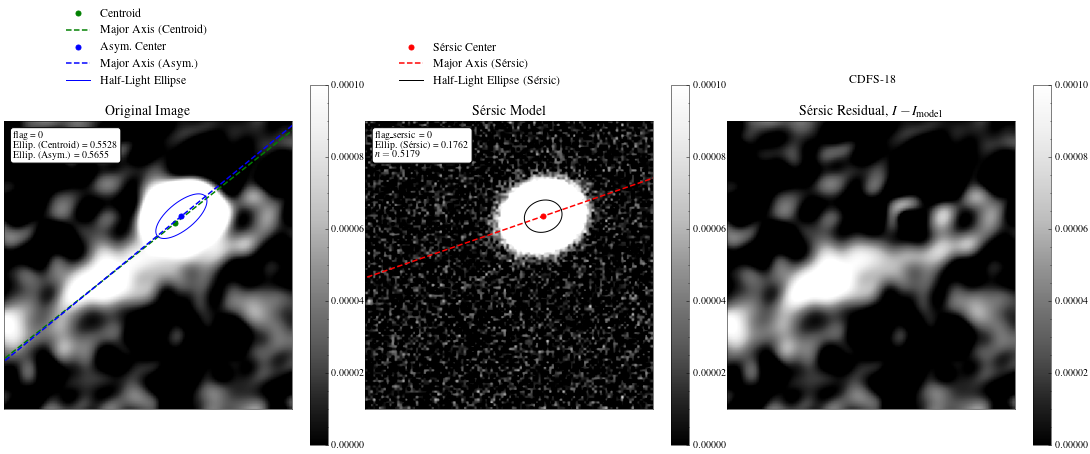

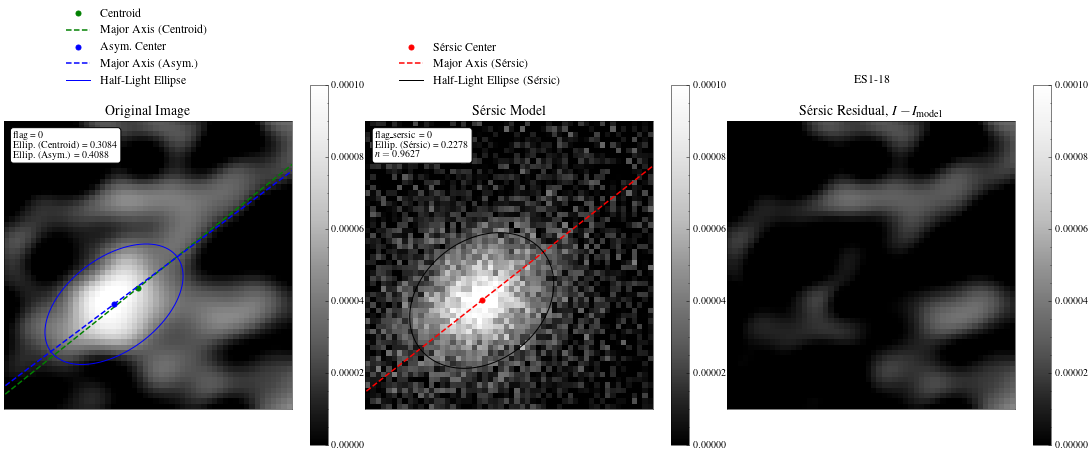

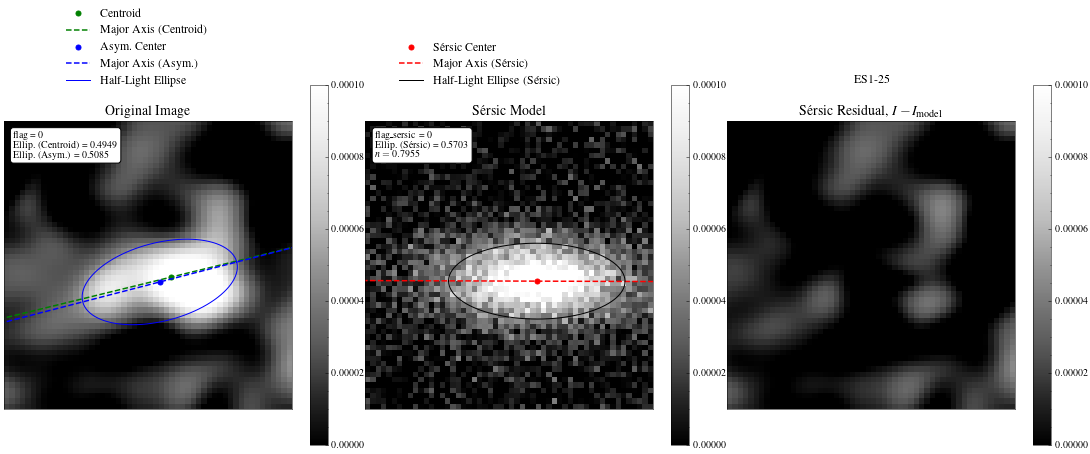

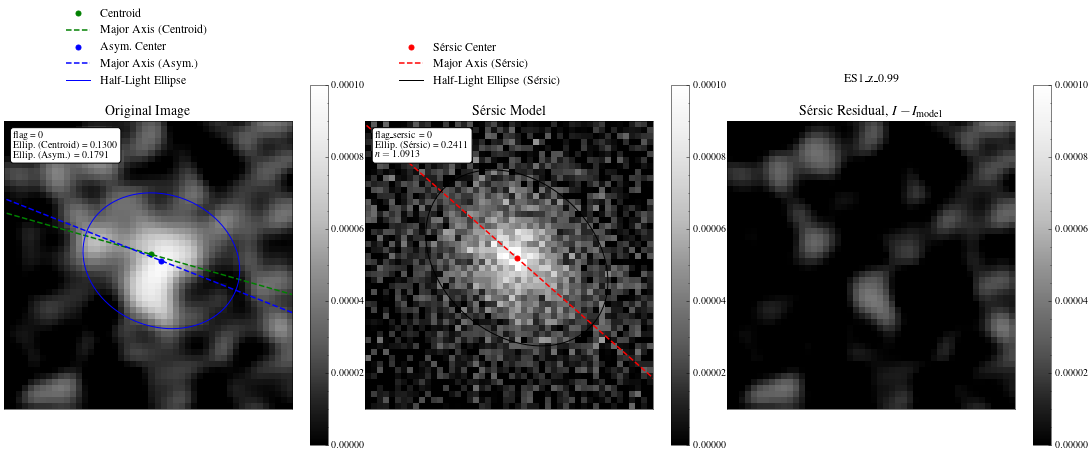

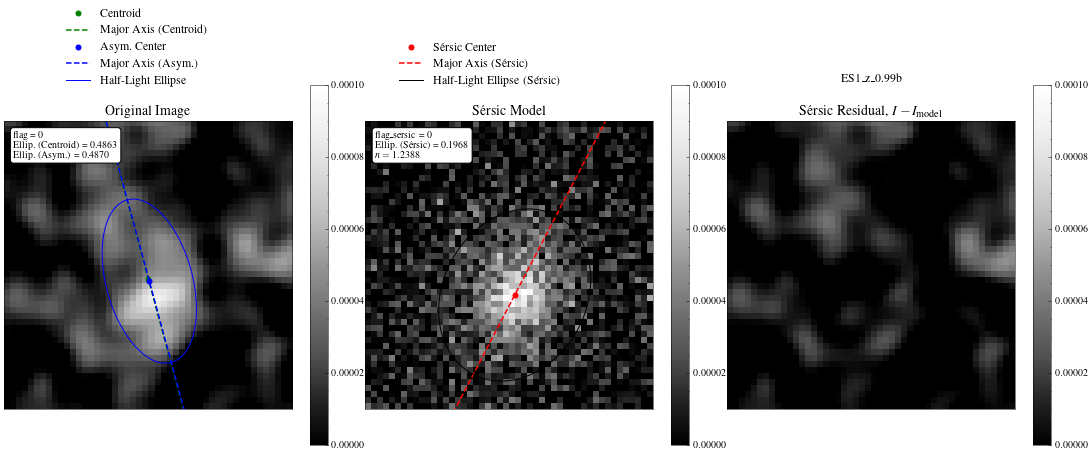

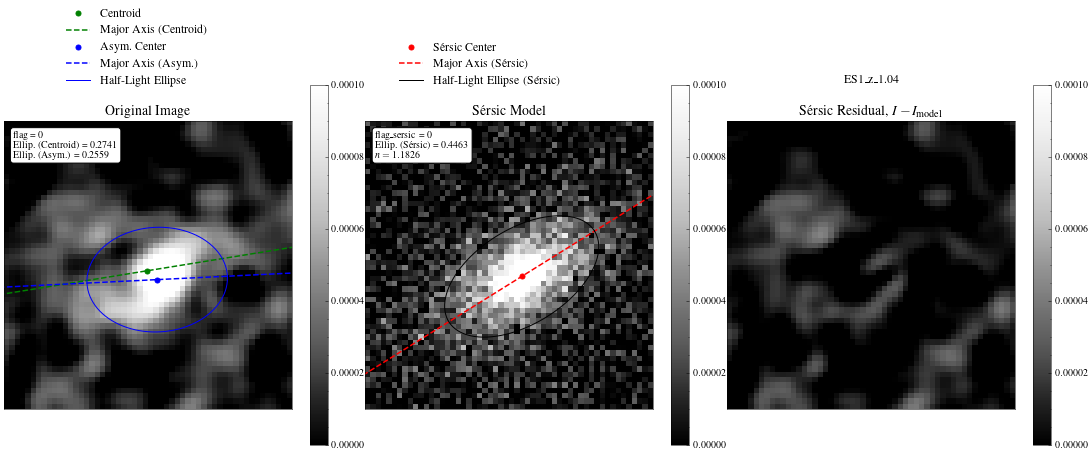

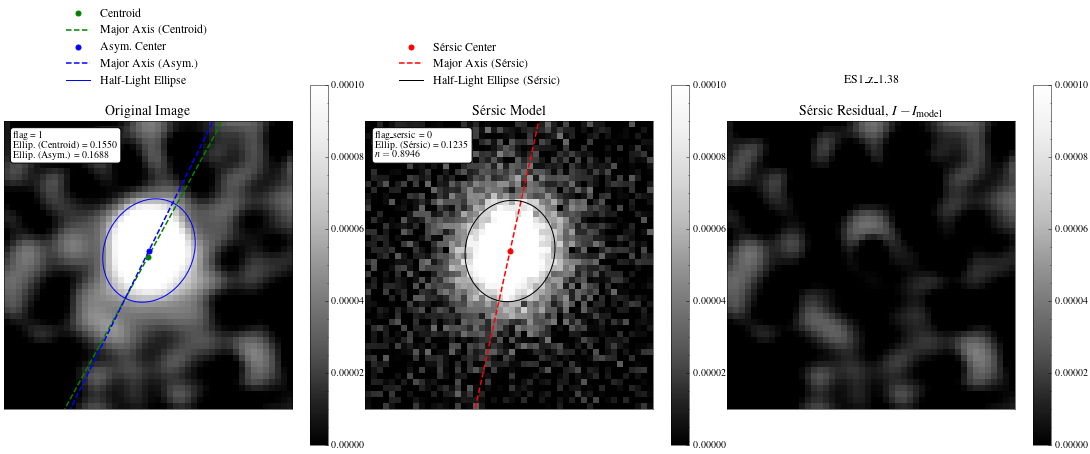

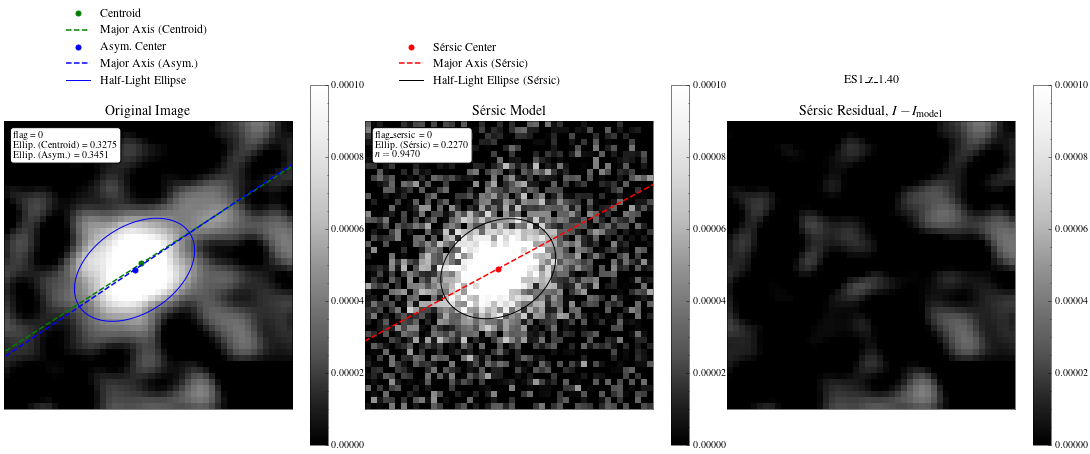

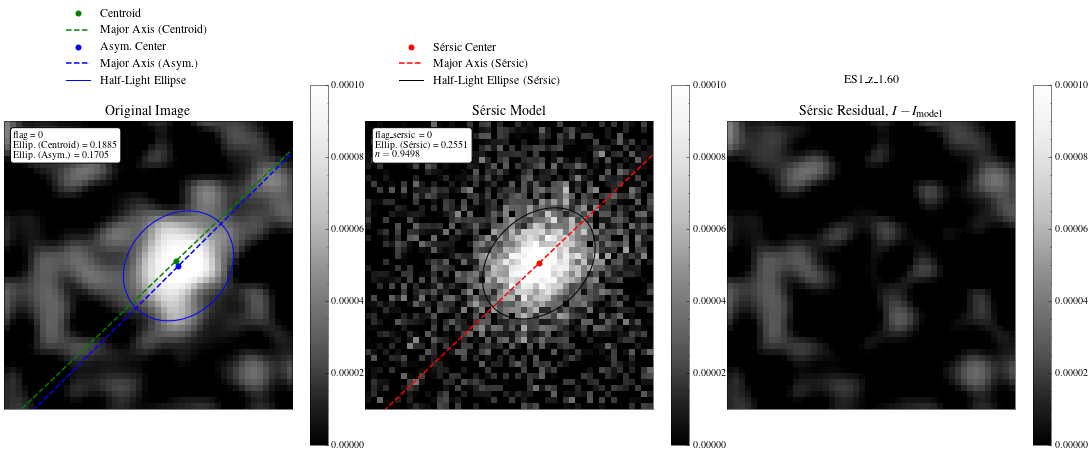

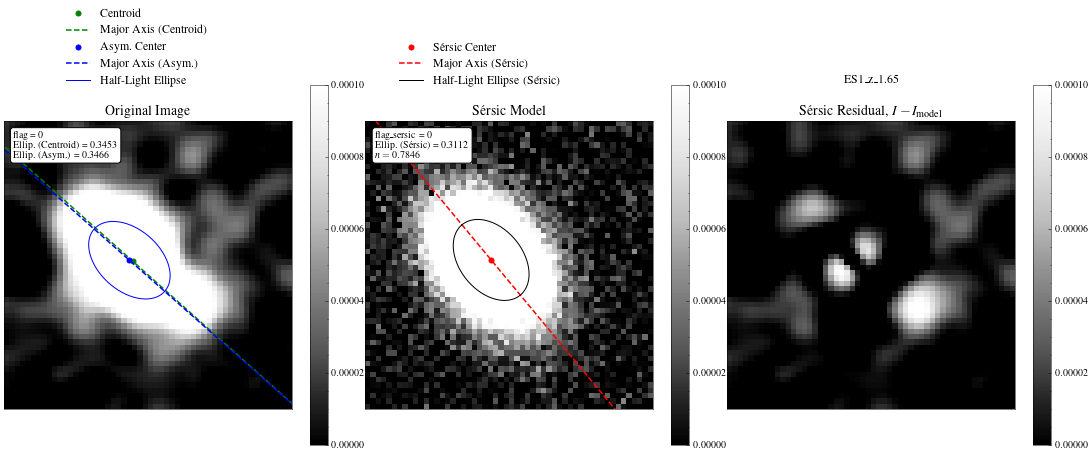

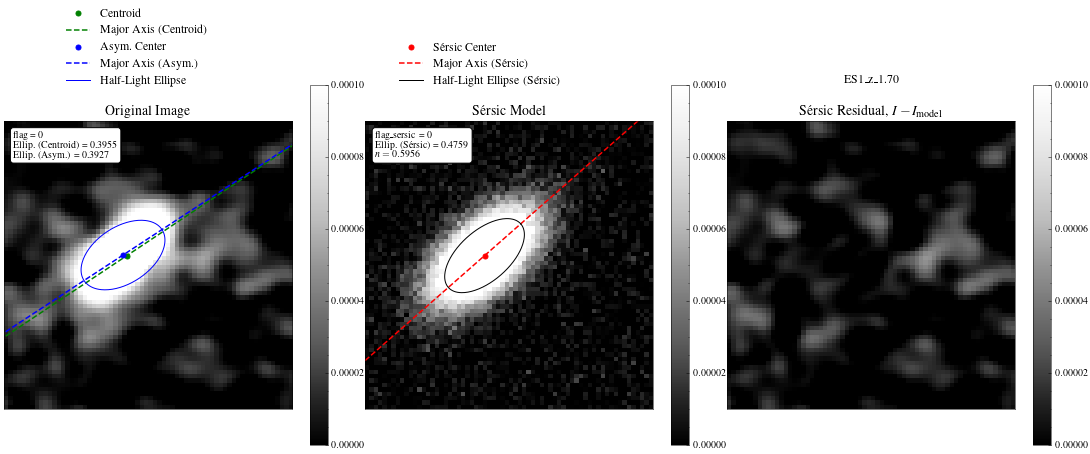

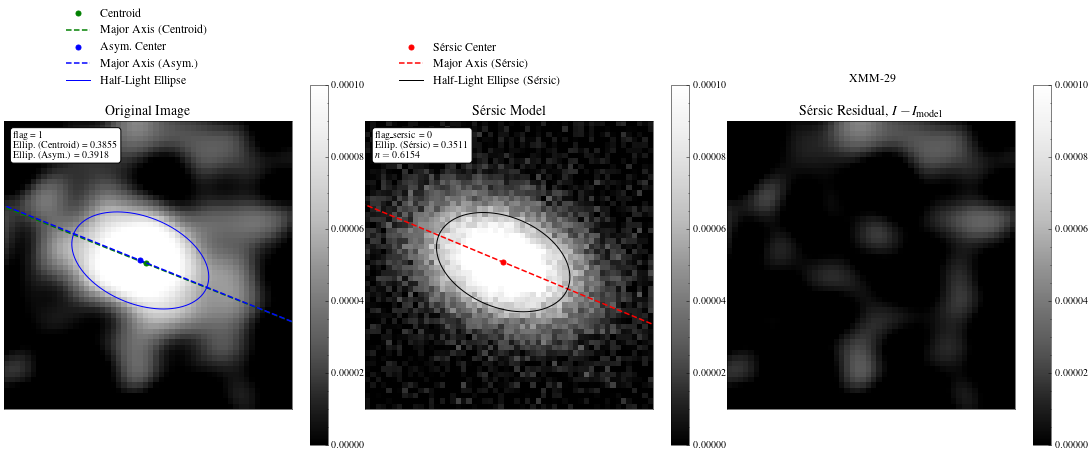

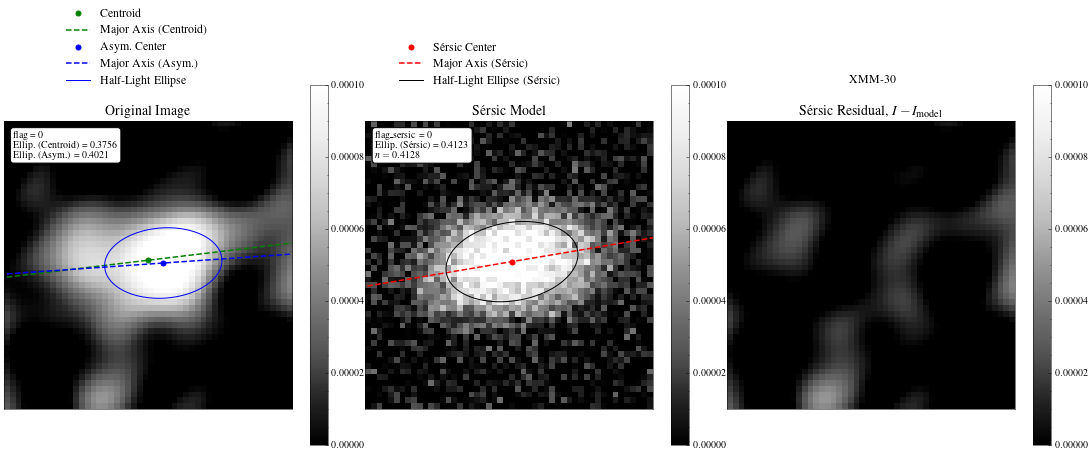

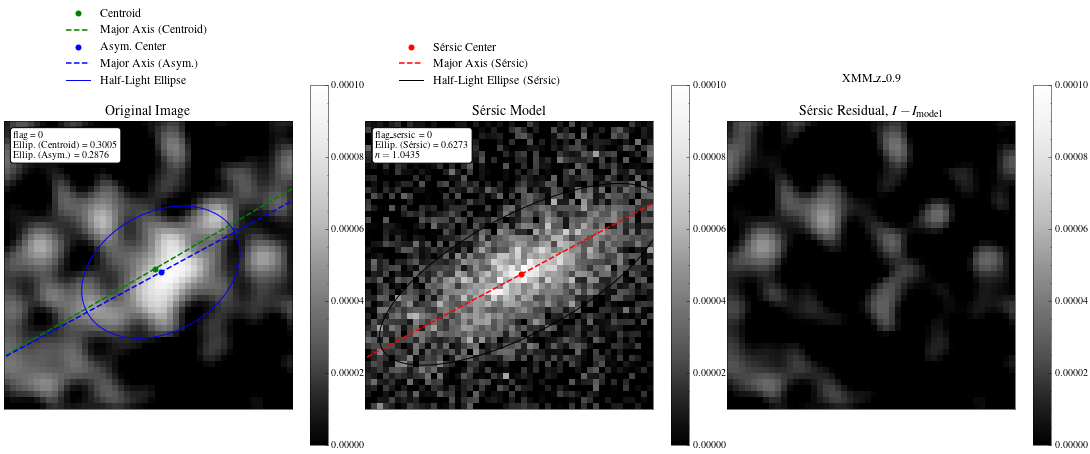

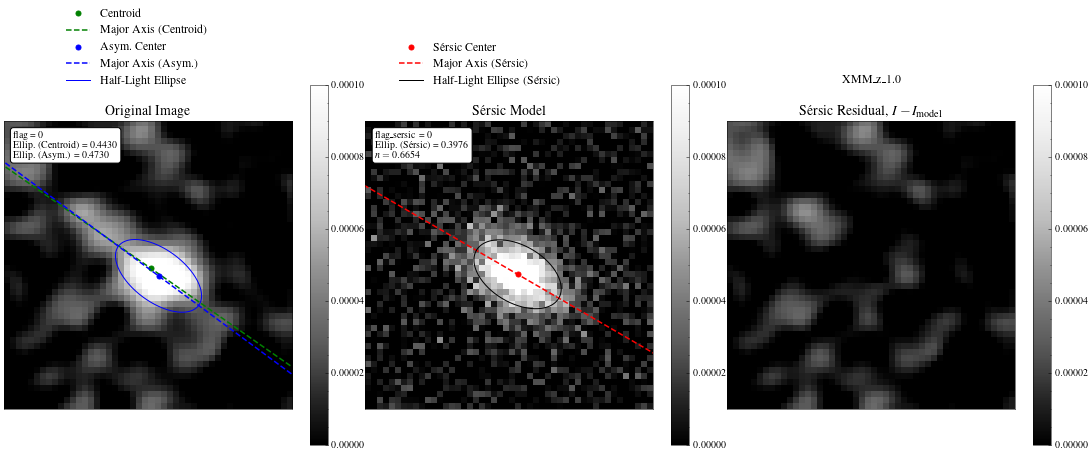

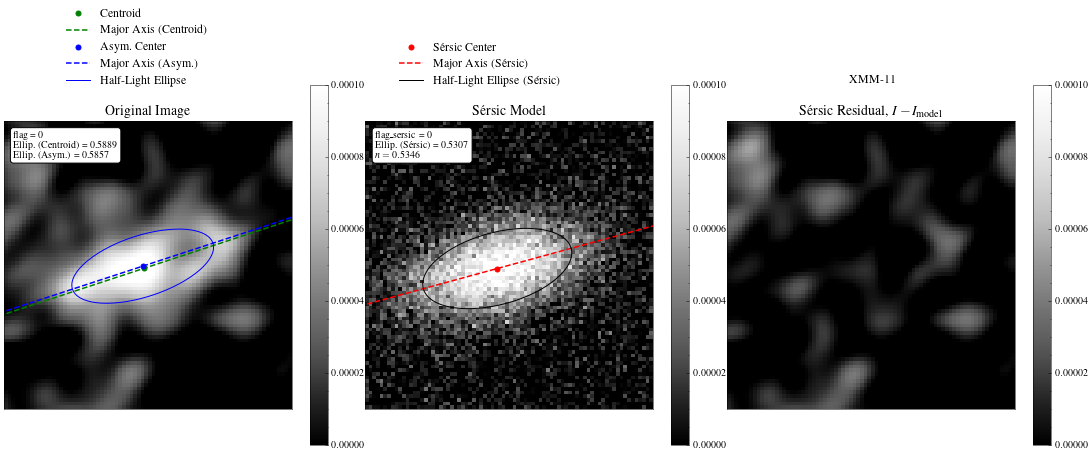

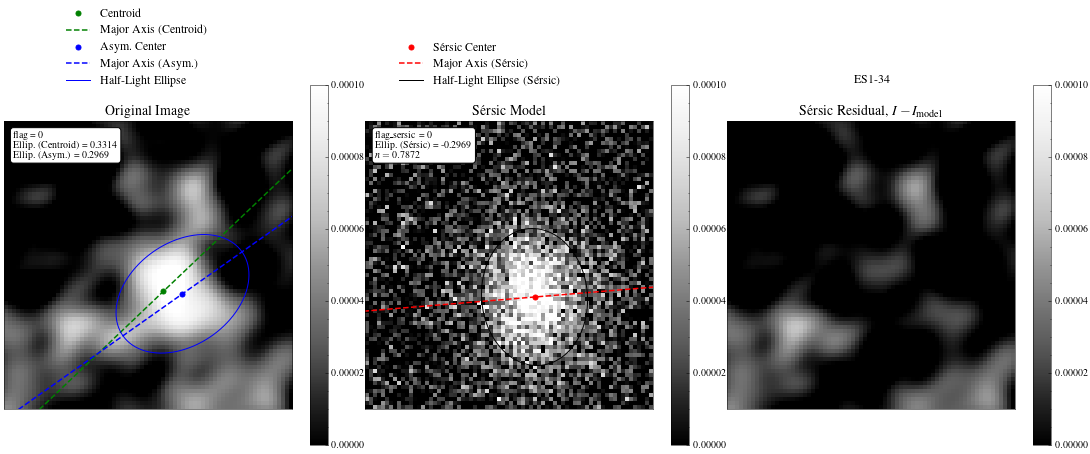

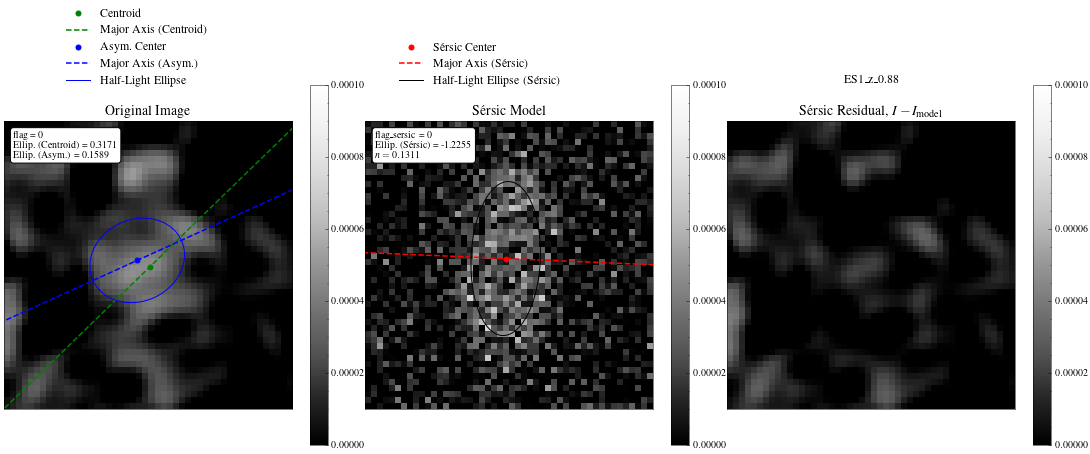

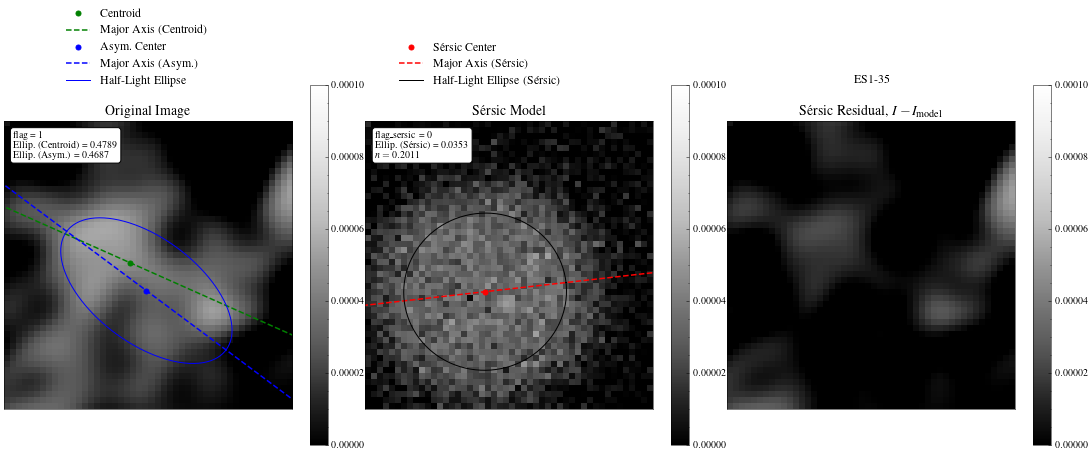

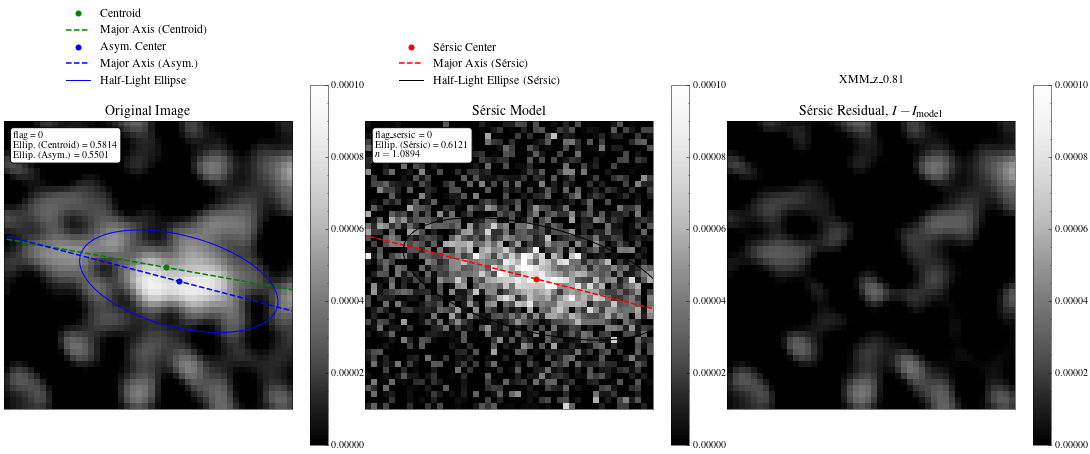

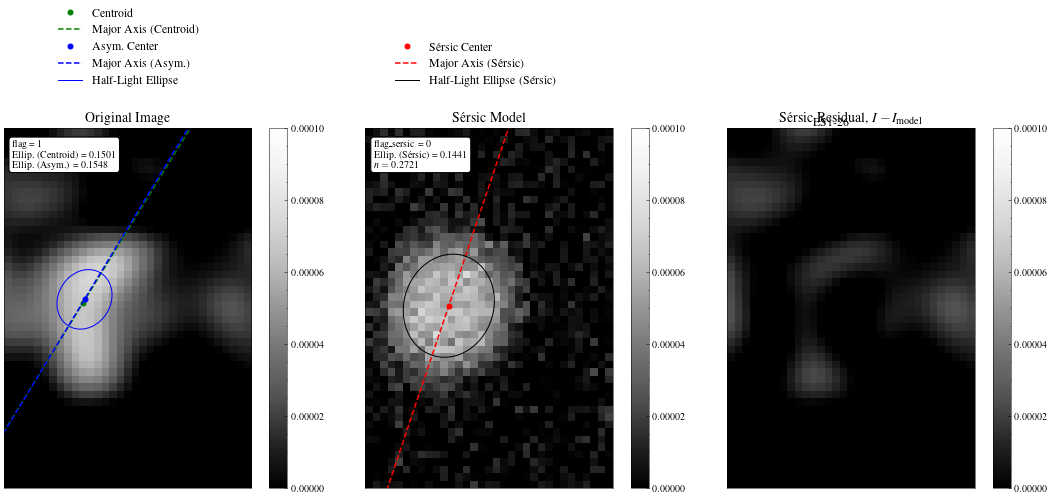

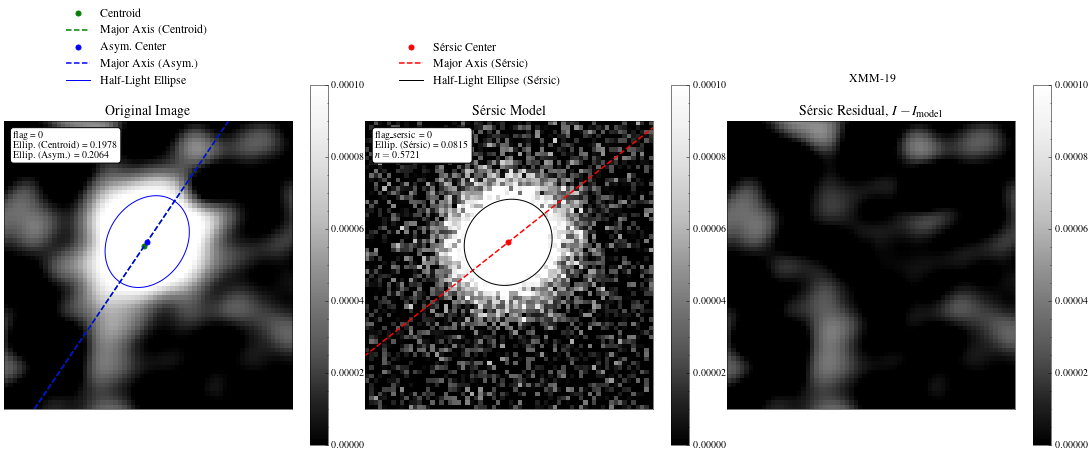

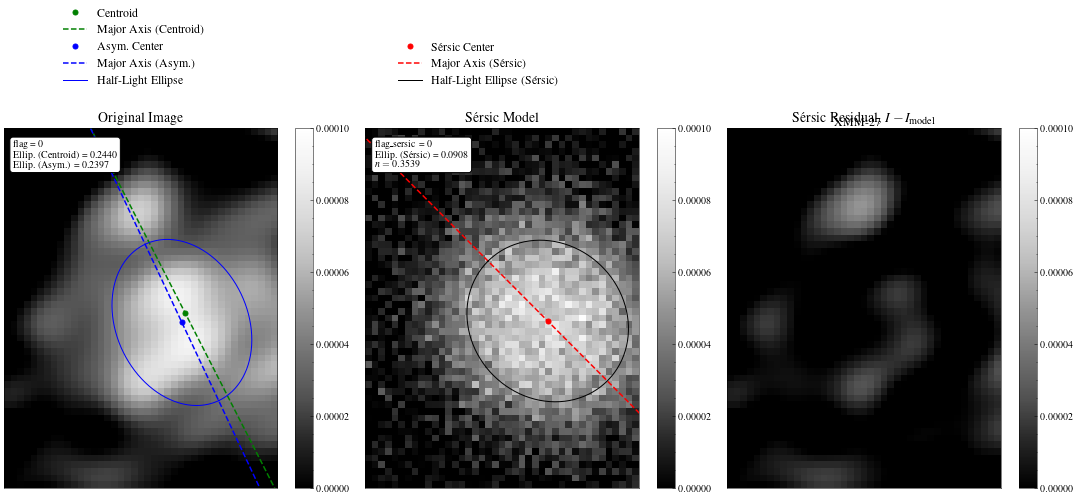

In [42]:
%matplotlib inline
for bcg in list(results.index):
    try:
        morph = compute_sersic_beam(bcg)
        fig = make_figure(morph)
        fig.suptitle(bcg, x = 0.8)
    except:
        pass

In [63]:
results.sort_values(by=['SFR'])

SFR     SFR_err  Stellar_mass  Stellar_mass_err  \
id                                                                     
ES1_z_0.88     16.339344    1.017821  6.758220e+10      9.687966e+09   
CDFS-18        23.824306    4.727115  1.538661e+11      1.550262e+10   
CDFS-19        33.475627    4.083425  1.555707e+11      1.086400e+10   
ES1-25         35.479174   20.181078  1.124215e+11      2.072337e+10   
ES1_z_0.99b    36.365577   11.760642  7.119149e+10      2.409869e+10   
ES1-18         38.219397    4.054495  1.639366e+11      1.784595e+10   
ES1-12         47.812017    6.006869  1.995936e+11      3.011822e+10   
ES1-26         50.997303   12.405896  2.988946e+11      2.188373e+10   
ES1_z_1.70     54.777962    4.758204  1.145421e+11      8.975100e+09   
XMM_z_1.0      65.761578   22.044591  5.580171e+10      1.894427e+10   
XMM_z_0.9      70.836925   19.586493  1.042527e+11      1.300711e+10   
XMM-19         78.394902    3.919745  8.740998e+10      4.867738e+09   
XMM_z_0.81    117.641453   55.926071  1.024312e+11      2.219733e+10   
XMM_113       122.218776   89.956725  3.950012e+11      8.475127e+10   
ES1_z_0.99    152.570824  142.756763  7.522039e+10      9.566821e+09   
XMM-27        154.177812   32.596748  2.143111e+11      2.945263e+10   
ES1-34        269.194180   14.891471  6.072108e+11      7.113255e+10   
ES1_z_1.04    312.219795  148.304865  9.512975e+10      1.959103e+10   
XMM-30        381.735158   50.399395  1.121162e+11      1.703403e+10   
ES1-35        435.795776   60.301348  2.459066e+11      3.289271e+10   
XMM-11        461.356198  215.942380  1.246505e+11      3.739041e+10   
XMM-29        621.233288   37.802112  1.403555e+11      1.232890e+10   
ES1_z_1.60    682.670994   48.321684  1.453804e+11      1.047361e+10   
ES1_z_1.38    779.855401  185.052349  1.231801e+11      1.131030e+10   
ES1_z_1.40    785.503591   97.363627  7.781236e+10      1.121162e+10   
ES1_z_1.65   1306.491825   86.606746  2.793319e+11      2.580349e+10   

             reduced_chi_square          sSFR      sSFR_err   sSFR_gyr  \
id                                                                       
ES1_z_0.88             2.009905  2.417699e-10  3.778875e-11   0.241770   
CDFS-18                9.306043  1.548379e-10  3.445627e-11   0.154838   
CDFS-19                1.182378  2.151794e-10  3.024499e-11   0.215179   
ES1-25                 1.620694  3.155908e-10  1.887038e-10   0.315591   
ES1_z_0.99b            1.009473  5.108135e-10  2.391424e-10   0.510814   
ES1-18                 1.720605  2.331352e-10  3.543672e-11   0.233135   
ES1-12                 2.378459  2.395469e-10  4.703564e-11   0.239547   
ES1-26                 2.953507  1.706197e-10  4.334503e-11   0.170620   
ES1_z_1.70             2.810916  4.782344e-10  5.594521e-11   0.478234   
XMM_z_1.0              6.436920  1.178487e-09  5.622600e-10   1.178487   
XMM_z_0.9              0.715005  6.794732e-10  2.061160e-10   0.679473   
XMM-19                 5.393139  8.968644e-10  6.712248e-11   0.896864   
XMM_z_0.81             2.232051  1.148493e-09  6.000373e-10   1.148493   
XMM_113                2.354772  3.094137e-10  2.372169e-10   0.309414   
ES1_z_0.99             1.244926  2.028317e-09  1.915299e-09   2.028317   
XMM-27                 6.010726  7.194113e-10  1.814094e-10   0.719411   
ES1-34                 3.619022  4.433290e-10  5.743367e-11   0.443329   
ES1_z_1.04             5.153100  3.282042e-09  1.699191e-09   3.282042   
XMM-30                 1.367169  3.404818e-09  6.853288e-10   3.404818   
ES1-35                 2.413791  1.772201e-09  3.410666e-10   1.772201   
XMM-11                 1.790640  3.701197e-09  2.057604e-09   3.701197   
XMM-29                 3.043430  4.426140e-09  4.729696e-10   4.426140   
ES1_z_1.60             9.750097  4.695757e-09  4.742585e-10   4.695757   
ES1_z_1.38             5.326554  6.331018e-09  1.610838e-09   6.331018   
ES1_z_1.40             5.085912  1.009484e-08  1.918666e-09  10.094843   
ES1_z_

In [194]:
def save_sersic_results():
    sersic_profile = {}
    good_detections = ["CDFS-18", "ES1-18", "ES1-25", "ES1_z_0.99","ES1_z_0.99b","ES1_z_1.04","ES1_z_1.38","ES1_z_1.40",
"ES1_z_1.60", "ES1_z_1.65", "ES1_z_1.70", "XMM-113", "XMM-29", "XMM-30", "XMM_z_0.9", "XMM_z_1.0"]
    for bcg in good_detections:
        morph = compute_sersic(bcg)
        fig = make_figure(morph)
        fig.suptitle(bcg, x = 0.8)
        fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/" + bcg + "_sersic.png", dpi = 300)
        sersic_profile[bcg] = (morph.sersic_n, morph.sersic_rhalf * 0.045)
    return sersic_profile


{'CDFS-18': (0.517900702959268, 0.3234972249750695),
 'ES1-18': (0.9002263317116567, 0.6375488449350732),
 'ES1-25': (0.6921047831881519, 0.6691584791708564),
 'ES1_z_0.99': (1.0913055654857096, 0.7564233662553768),
 'ES1_z_0.99b': (1.2567262701761712, 0.7159313072309245),
 'ES1_z_1.04': (1.234250764422008, 0.7519617532761311),
 'ES1_z_1.38': (0.898204726828569, 0.3838058913994024),
 'ES1_z_1.40': (0.9469692953472915, 0.4520922346595077),
 'ES1_z_1.60': (0.9021332731420164, 0.456607053914986),
 'ES1_z_1.65': (0.7857547112456803, 0.38570209382849796),
 'ES1_z_1.70': (0.5828426492959523, 0.4920817139716297),
 'XMM-113': (1.4695521150284603, 0.7675831311186924),
 'XMM-29': (0.624402514059679, 0.5932487685866871),
 'XMM-30': (0.3893268752386015, 0.5092209344285583),
 'XMM_z_0.9': (1.004919654716117, 1.0115600097540063),
 'XMM_z_1.0': (0.6653306535881347, 0.3571189959245823)}

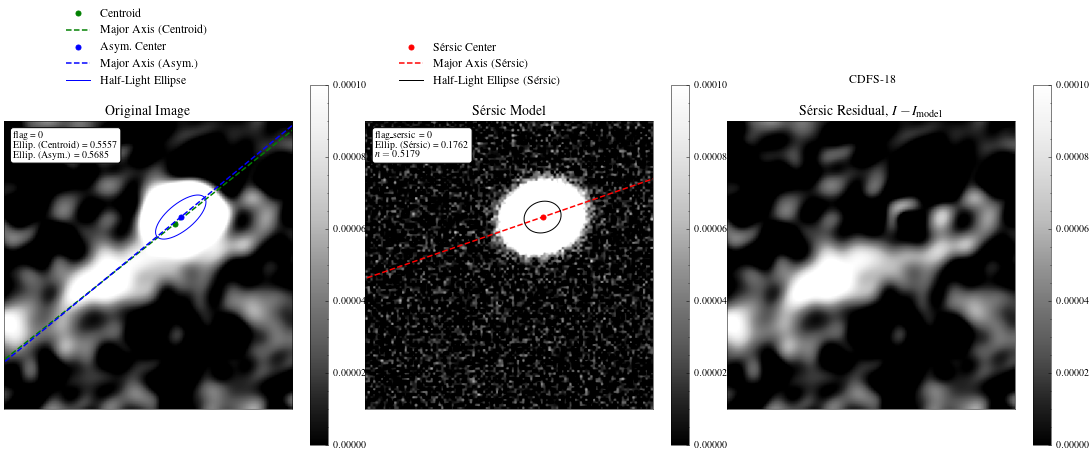

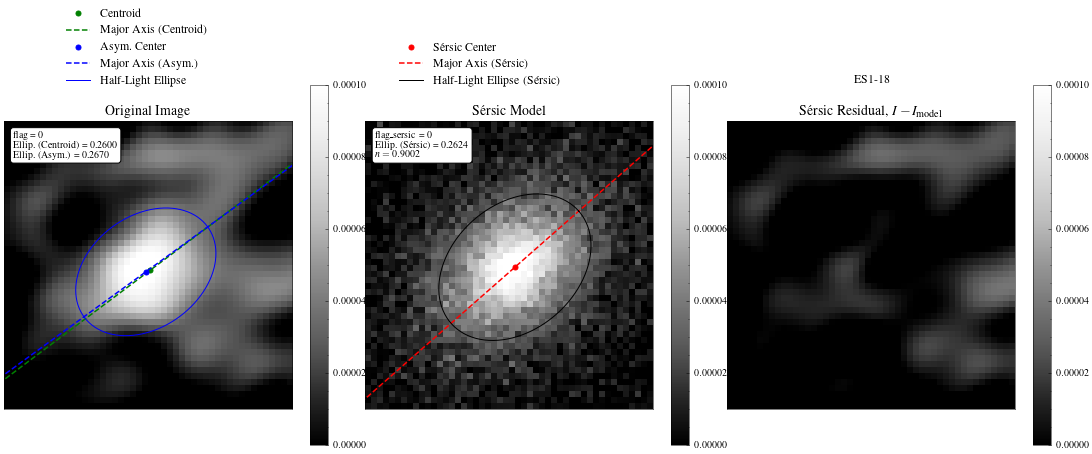

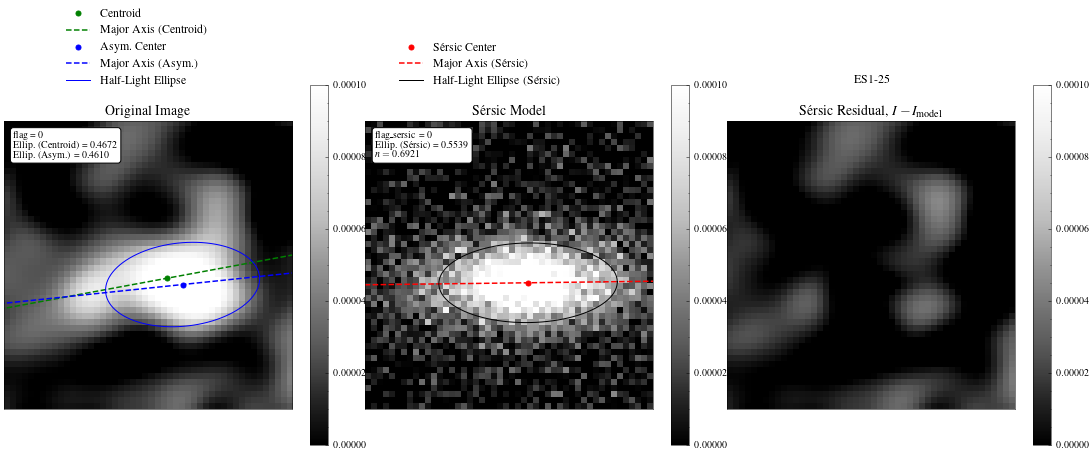

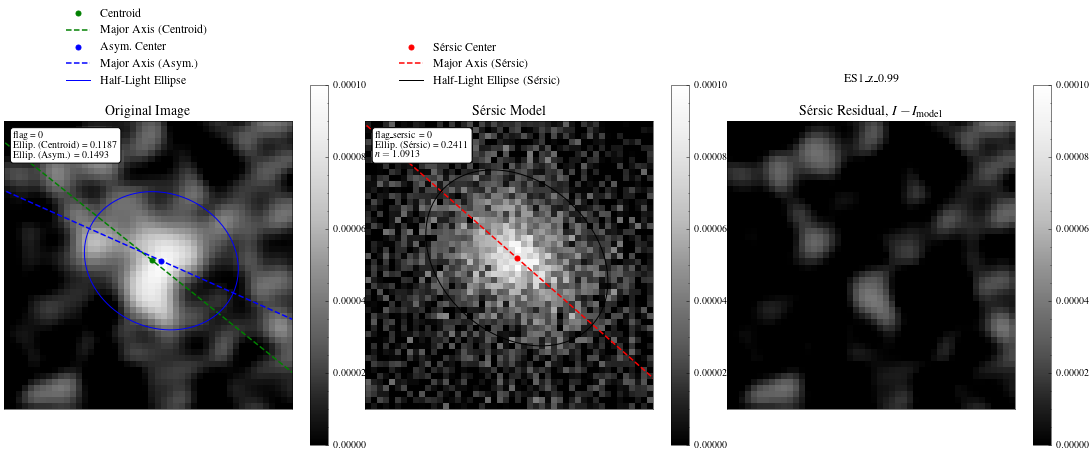

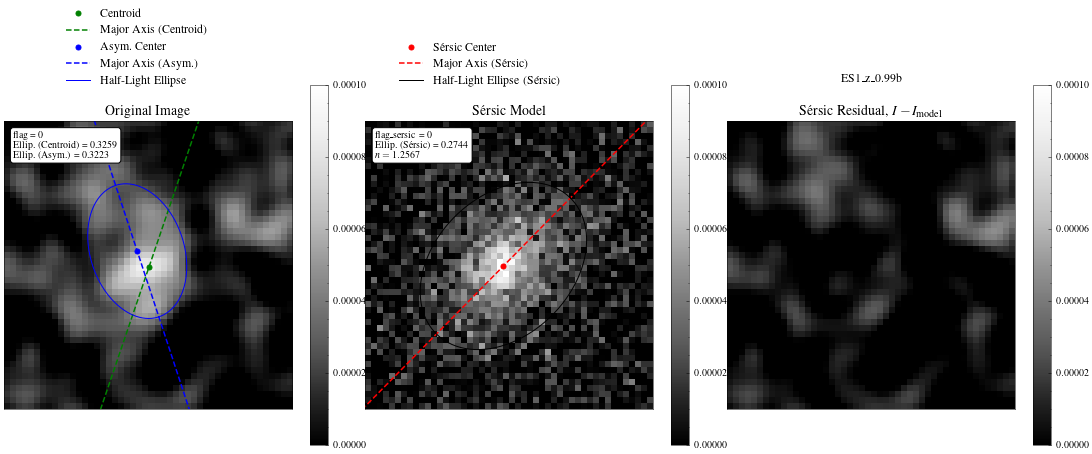

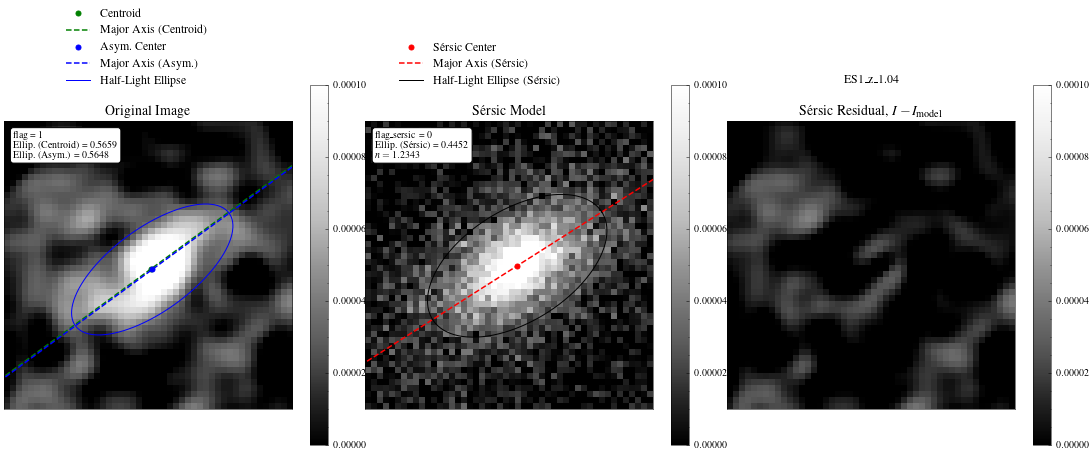

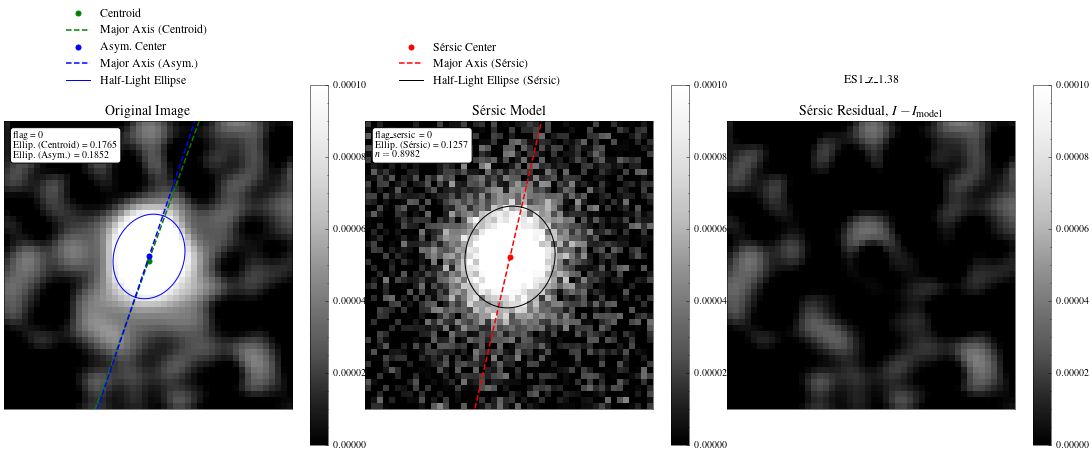

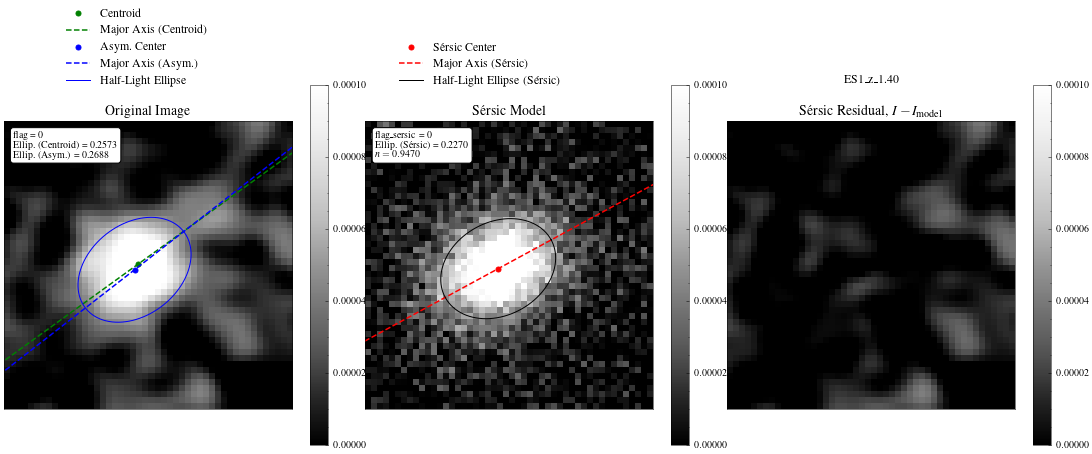

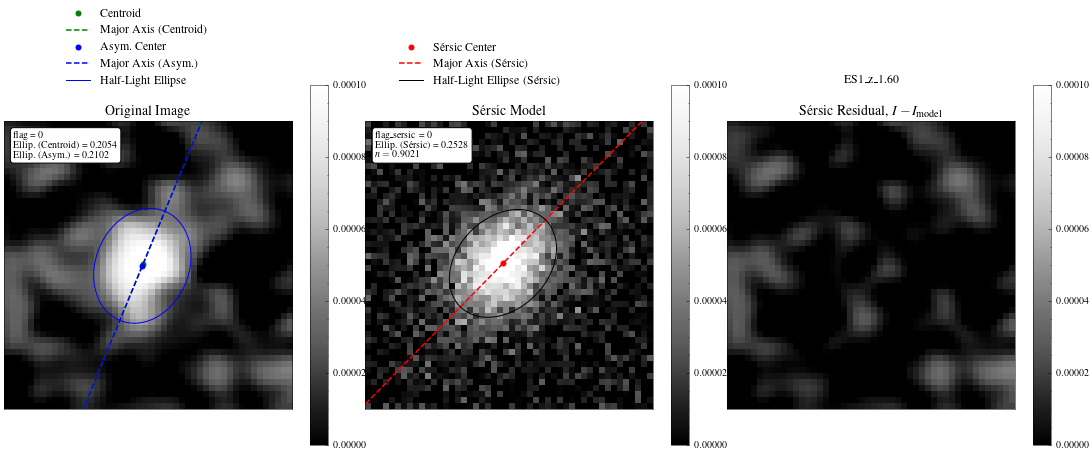

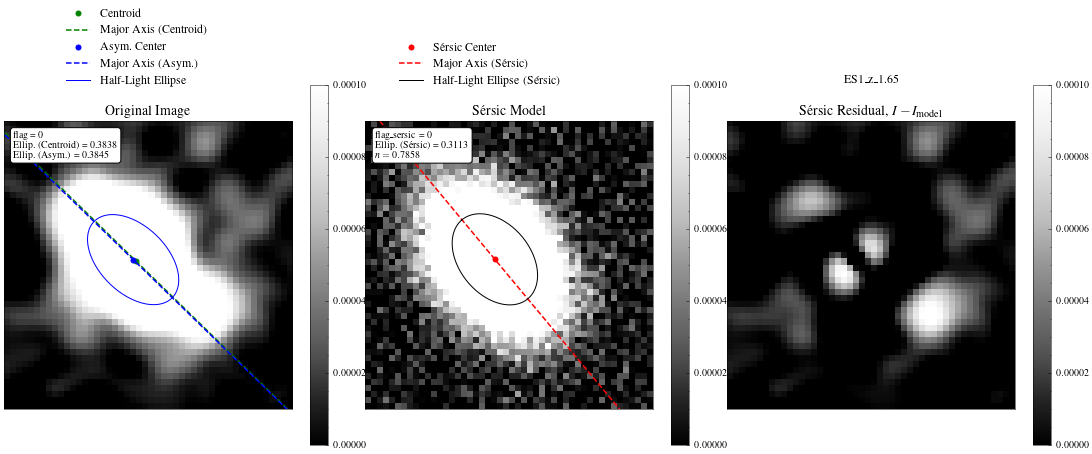

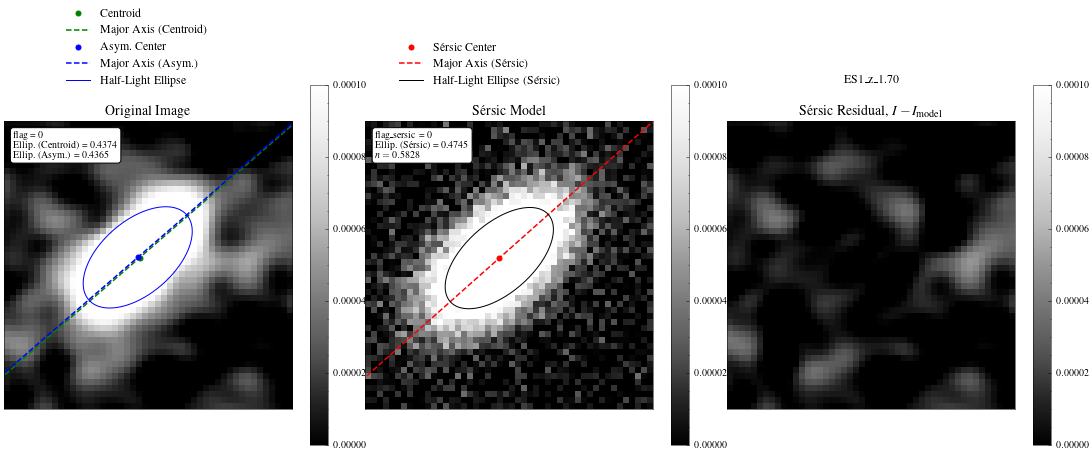

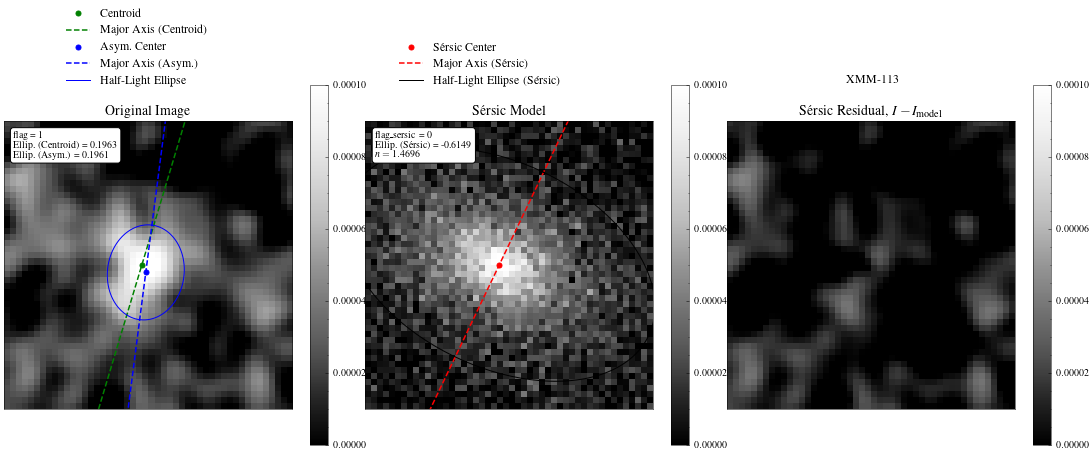

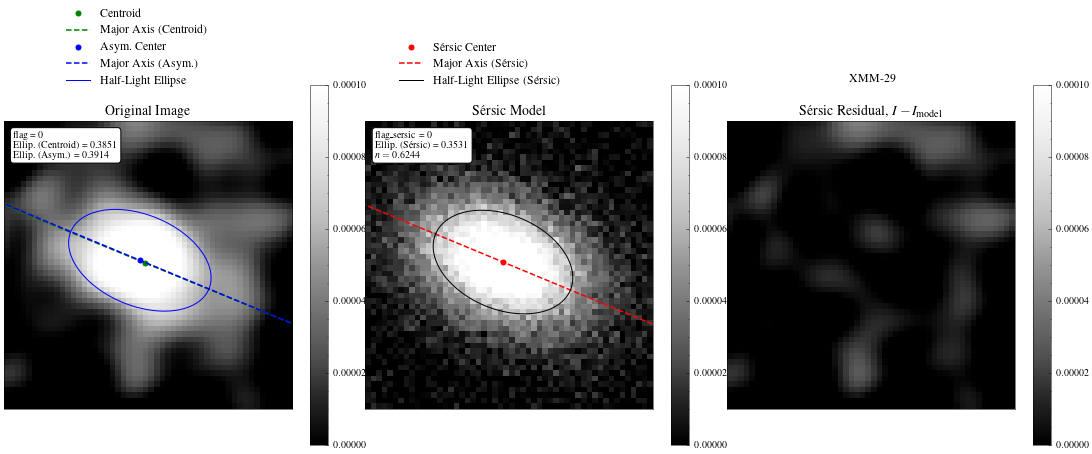

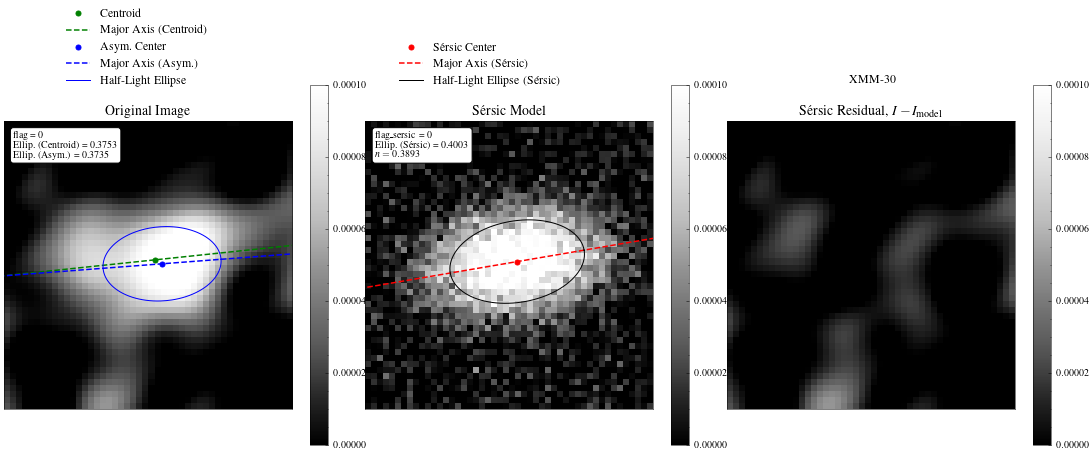

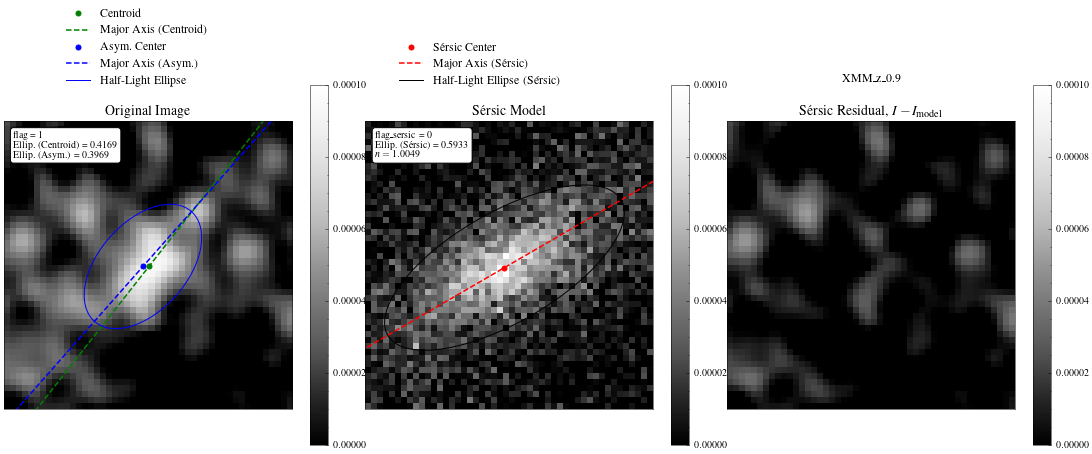

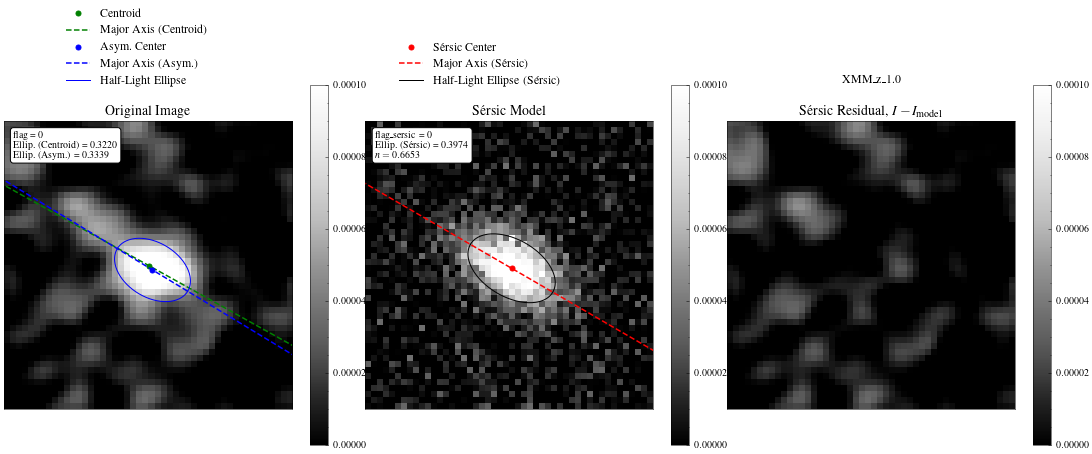

In [195]:
sersic_profile_results = save_sersic_results()

In [217]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
from decimal import *
import pandas as pd
from math import *
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii
import glob
import os
import matplotlib.pyplot as plt
import matplotlib

all_bcgs = ['CDFS-18',
 'CDFS19',
 'ES1-12',
 'ES1-18',
 'ES1-25',
 'ES1-26',
 'ES1-34',
 'ES1-35',
 'XMM-11',
 'XMM-19',
 'XMM-27',
 'XMM-29',
 'XMM-30',
 'ES1_z_0.88',
 'ES1_z_0.99',
 'ES1_z_0.99b',
 'ES1_z_1.04',
 'ES1_z_1.38',
 'ES1_z_1.40',
 'ES1_z_1.60',
 'ES1_z_1.65',
 'ES1_z_1.70',
 'XMM-113',
 'XMM_z_0.9',
 'XMM_z_1.0',
 'XMM_z_0.81']

results = pd.DataFrame(columns = ["bcg","SFR", "SFR_err", "Stellar_mass", "Stellar_mass_err", "reduced_chi_square"])
for bcg in all_bcgs:
    path = "/Users/arames52/Downloads/cigale-v2020.0/pcigale/data/" + bcg + "/out/results.fits"
    data = Table(fits.open(path)[1].data)
    reqd = data[['id','bayes.sfh.sfr', 'bayes.sfh.sfr_err', 'bayes.stellar.m_star', 'bayes.stellar.m_star_err', 'best.reduced_chi_square']].to_pandas()
    reqd = reqd.rename(columns = {"id": "bcg",'bayes.sfh.sfr':"SFR", 'bayes.sfh.sfr_err':"SFR_err", 'bayes.stellar.m_star':"Stellar_mass", 'bayes.stellar.m_star_err':"Stellar_mass_err", "best.reduced_chi_square": "reduced_chi_square"})
    results = pd.concat([results, reqd]).reset_index(drop=True)

print(results)

            bcg          SFR     SFR_err  Stellar_mass  Stellar_mass_err  \
0       CDFS-18    23.824306    4.727115  1.538661e+11      1.550262e+10   
1       CDFS-19    33.475627    4.083425  1.555707e+11      1.086400e+10   
2        ES1-12    47.812017    6.006869  1.995936e+11      3.011822e+10   
3        ES1-18    38.219397    4.054495  1.639366e+11      1.784595e+10   
4        ES1-25    35.479174   20.181078  1.124215e+11      2.072337e+10   
5        ES1-26    50.997303   12.405896  2.988946e+11      2.188373e+10   
6        ES1-34   527.775991   44.067429  5.363627e+11      7.069561e+10   
7        ES1-35   435.795776   60.301348  2.459066e+11      3.289271e+10   
8        XMM-11   461.356198  215.942380  1.246505e+11      3.739041e+10   
9        XMM-19    78.394902    3.919745  8.740998e+10      4.867738e+09   
10       XMM-27   154.177812   32.596748  2.143111e+11      2.945263e+10   
11       XMM-29   621.233288   37.802112  1.403555e+11      1.232890e+10   
12       XMM

In [3]:
df = pd.read_csv("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/results_table.csv")
    

In [4]:
img_df = pd.read_csv("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/bcg_properties.csv")

In [5]:
master_df = pd.concat([df, img_df[['id', 'S/N']]], axis = 1)

Text(0.5, 0, 'Redshift')

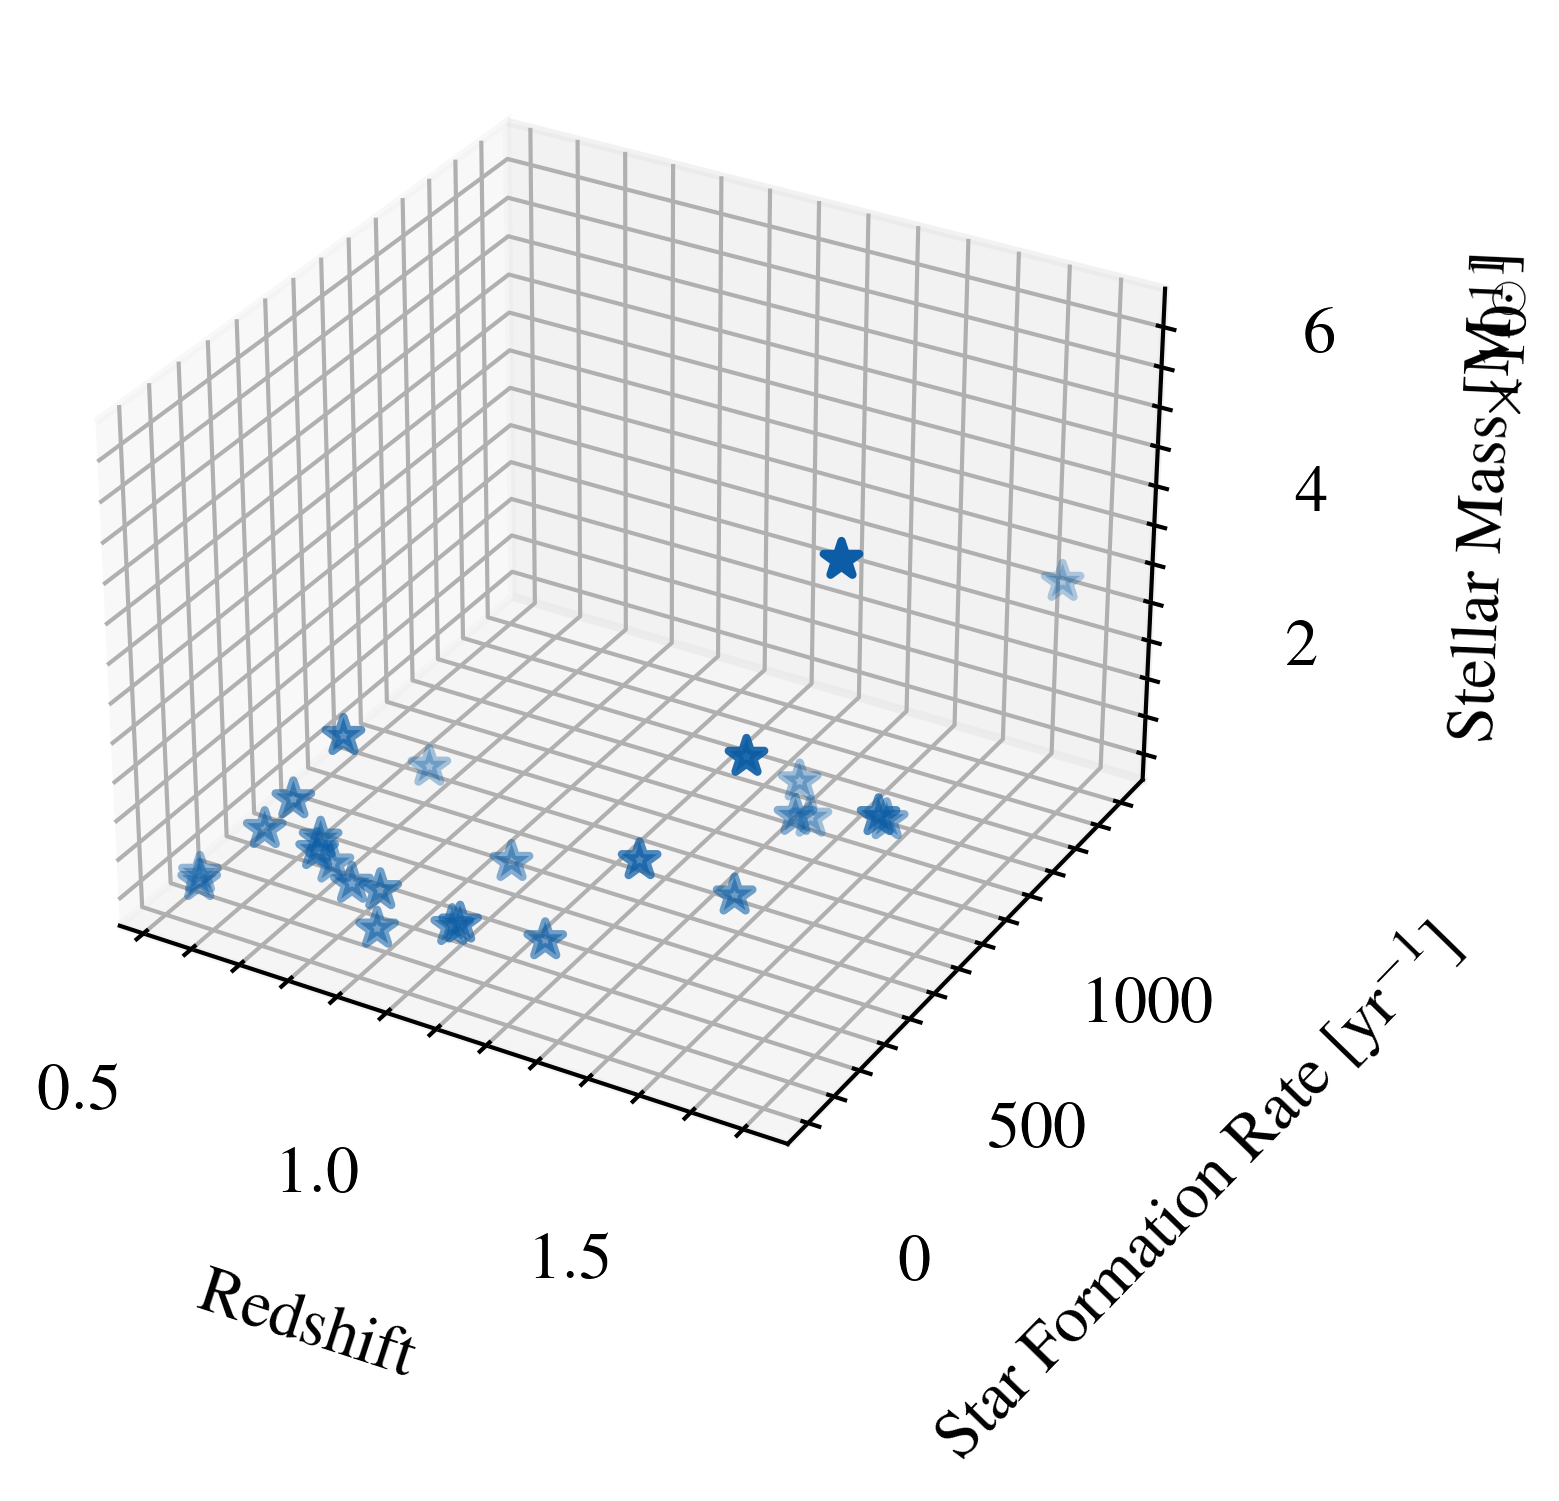

In [25]:
# SFR vs Mstar Plot
%matplotlib inline
plt.style.use(["ieee","science"])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['redshift'], df['SFR'], df['Stellar_mass'], marker = '*')
ax.set_zlabel("Stellar Mass [M$_\odot$]")
ax.set_ylabel("Star Formation Rate [yr$^{-1}$]")
ax.set_xlabel("Redshift")
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.legend()


In [6]:
df.sort_values(by=['Stellar_mass'])

id          SFR     SFR_err  Stellar_mass  Stellar_mass_err  \
15    XMM_z_1.0    65.761578   22.044591  5.580171e+10      1.894427e+10   
19   ES1_z_0.88    16.339344    1.017821  6.758220e+10      9.687966e+09   
4   ES1_z_0.99b    36.365577   11.760642  7.119149e+10      2.409869e+10   
3    ES1_z_0.99   152.570824  142.756763  7.522039e+10      9.566821e+09   
7    ES1_z_1.40   785.503591   97.363627  7.781236e+10      1.121162e+10   
24       XMM-19    78.394902    3.919745  8.740998e+10      4.867738e+09   
5    ES1_z_1.04   312.219795  148.304865  9.512975e+10      1.959103e+10   
21   XMM_z_0.81   117.641453   55.926071  1.024312e+11      2.219733e+10   
14    XMM_z_0.9    70.836925   19.586493  1.042527e+11      1.300711e+10   
13       XMM-30   381.735158   50.399395  1.121162e+11      1.703403e+10   
2        ES1-25    35.479174   20.181078  1.124215e+11      2.072337e+10   
10   ES1_z_1.70    54.777962    4.758204  1.145421e+11      8.975100e+09   
6    ES1_z_1.38   779.855401  185.052349  1.231801e+11      1.131030e+10   
16       XMM-11   461.356198  215.942380  1.246505e+11      3.739041e+10   
12       XMM-29   621.233288   37.802112  1.403555e+11      1.232890e+10   
8    ES1_z_1.60   682.670994   48.321684  1.453804e+11      1.047361e+10   
0       CDFS-18    23.824306    4.727115  1.538661e+11      1.550262e+10   
18      CDFS-19    33.475627    4.083425  1.555707e+11      1.086400e+10   
1        ES1-18    38.219397    4.054495  1.639366e+11      1.784595e+10   
22       ES1-12    47.812017    6.006869  1.995936e+11      3.011822e+10   
25       XMM-27   154.177812   32.596748  2.143111e+11      2.945263e+10   
20       ES1-35   435.795776   60.301348  2.459066e+11      3.289271e+10   
9    ES1_z_1.65  1306.491825   86.606746  2.793319e+11      2.580349e+10   
23       ES1-26    50.997303   12.405896  2.988946e+11      2.188373e+10   
11      XMM_113   122.218776   89.956725  3.950012e+11      8.475127e+10   
17       ES1-34   269.194180   14.891471  6.072108e+11      7.113255e+10   

    reduced_chi_square          sSFR      sSFR_err   sSFR_gyr  sSFR_err_gyr  \
15            6.436920  1.178487e-09  5.622600e-10   1.178487      0.562260   
19            2.009905  2.417699e-10  3.778875e-11   0.241770      0.037789   
4             1.009473  5.108135e-10  2.391424e-10   0.510814      0.239142   
3             1.244926  2.028317e-09  1.915299e-09   2.028317      1.915299   
7             5.085912  1.009484e-08  1.918666e-09  10.094843      1.918666   
24            5.393139  8.968644e-10  6.712248e-11   0.896864      0.067122   
5             5.153100  3.282042e-09  1.699191e-09   3.282042      1.699191   
21            2.232051  1.148493e-09  6.000373e-10   1.148493      0.600037   
14            0.715005  6.794732e-10  2.061160e-10   0.679473      0.206116   
13            1.367169  3.404818e-09  6.853288e-10   3.404818      0.685329   
2             1.620694  3.155908e-10  1.887038e-10   0.315591      0.188704   
10            2.810916  4.782344e-10  5.594521e-11   0.478234      0.055945   
6             5.326554  6.331018e-09  1.610838e-09   6.331018      1.610838   
16            1.790640  3.701197e-09  2.057604e-09   3.701197      2.057604   
12            3.043430  4.426140e-09  4.729696e-10   4.426140      0.472970   
8             9.750097  4.695757e-09  4.742585e-10   4.695757      0.474258   
0             9.306043  1.548379e-10  3.445627e-11   0.154838      0.034456   
18            1.182378  2.151794e-10  3.024499e-11   0.215179      0.030245   
1             1.720605  2.331352e-10  3.543672e-11   0.233135      0.035437   
22            2.378459  2.395469e-10  4.703564e-11   0.239547      0.047036   
25            6.010726  7.194113e-10  1.814094e-10   0.719411      0.181409   
20            2.413791  1.772201e-09  3.410666e-10   1.772201      0.341067   
9             5.305960  4.677203e-09  5.317956e-10   4.677203      0.531796   
23            2.953507  1.706197e-10  4.334503e-11   0.170620   

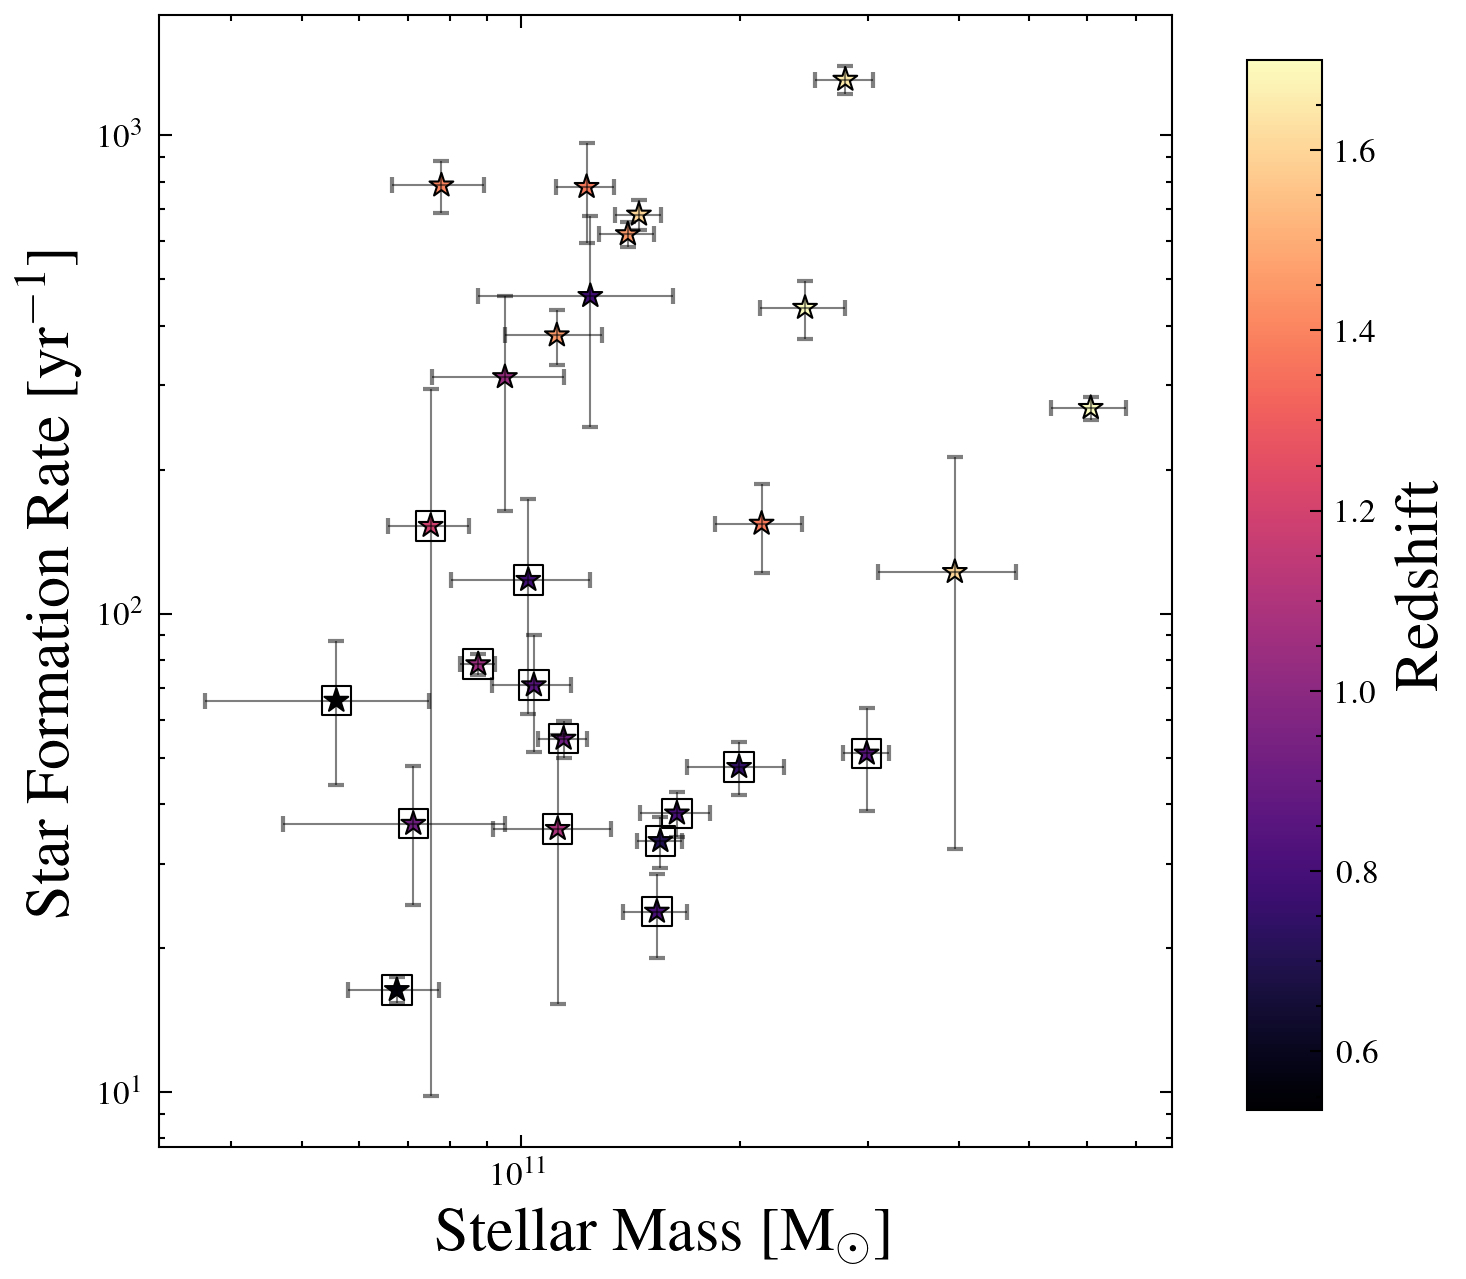

In [57]:
# SFR vs Mstar Plot
%matplotlib inline
vmin = min(master_df['redshift'])
vmax = max(master_df['redshift'])
plt.style.use(["ieee","science"])
fig, ax = plt.subplots(1,1,dpi = 300, figsize = (5,5))
im = ax.scatter(master_df['Stellar_mass'], master_df['SFR'], marker = '*',facecolors='none', c = master_df['redshift'], ec = 'black', lw = 0.5, vmin = vmin, vmax = vmax, cmap = 'magma')
ax.errorbar(master_df['Stellar_mass'], master_df['SFR'], xerr=master_df['Stellar_mass_err'],
yerr=master_df['SFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=2, elinewidth = 0.5)
specz = master_df[master_df['spec_z'] == 1]
ax.scatter(specz['Stellar_mass'], specz['SFR'], marker = 's', color = 'black', facecolors= 'none', lw = 0.5, s = 50, label = 'Spec_z')
ax.set_xlabel("Stellar Mass [M$_\odot$]", size = 15)
ax.set_ylabel("Star Formation Rate [yr$^{-1}$]", size = 15)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xticks(fontsize = 10)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("Redshift", size = 15)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/sfr_mstar.png", dpi = 300)

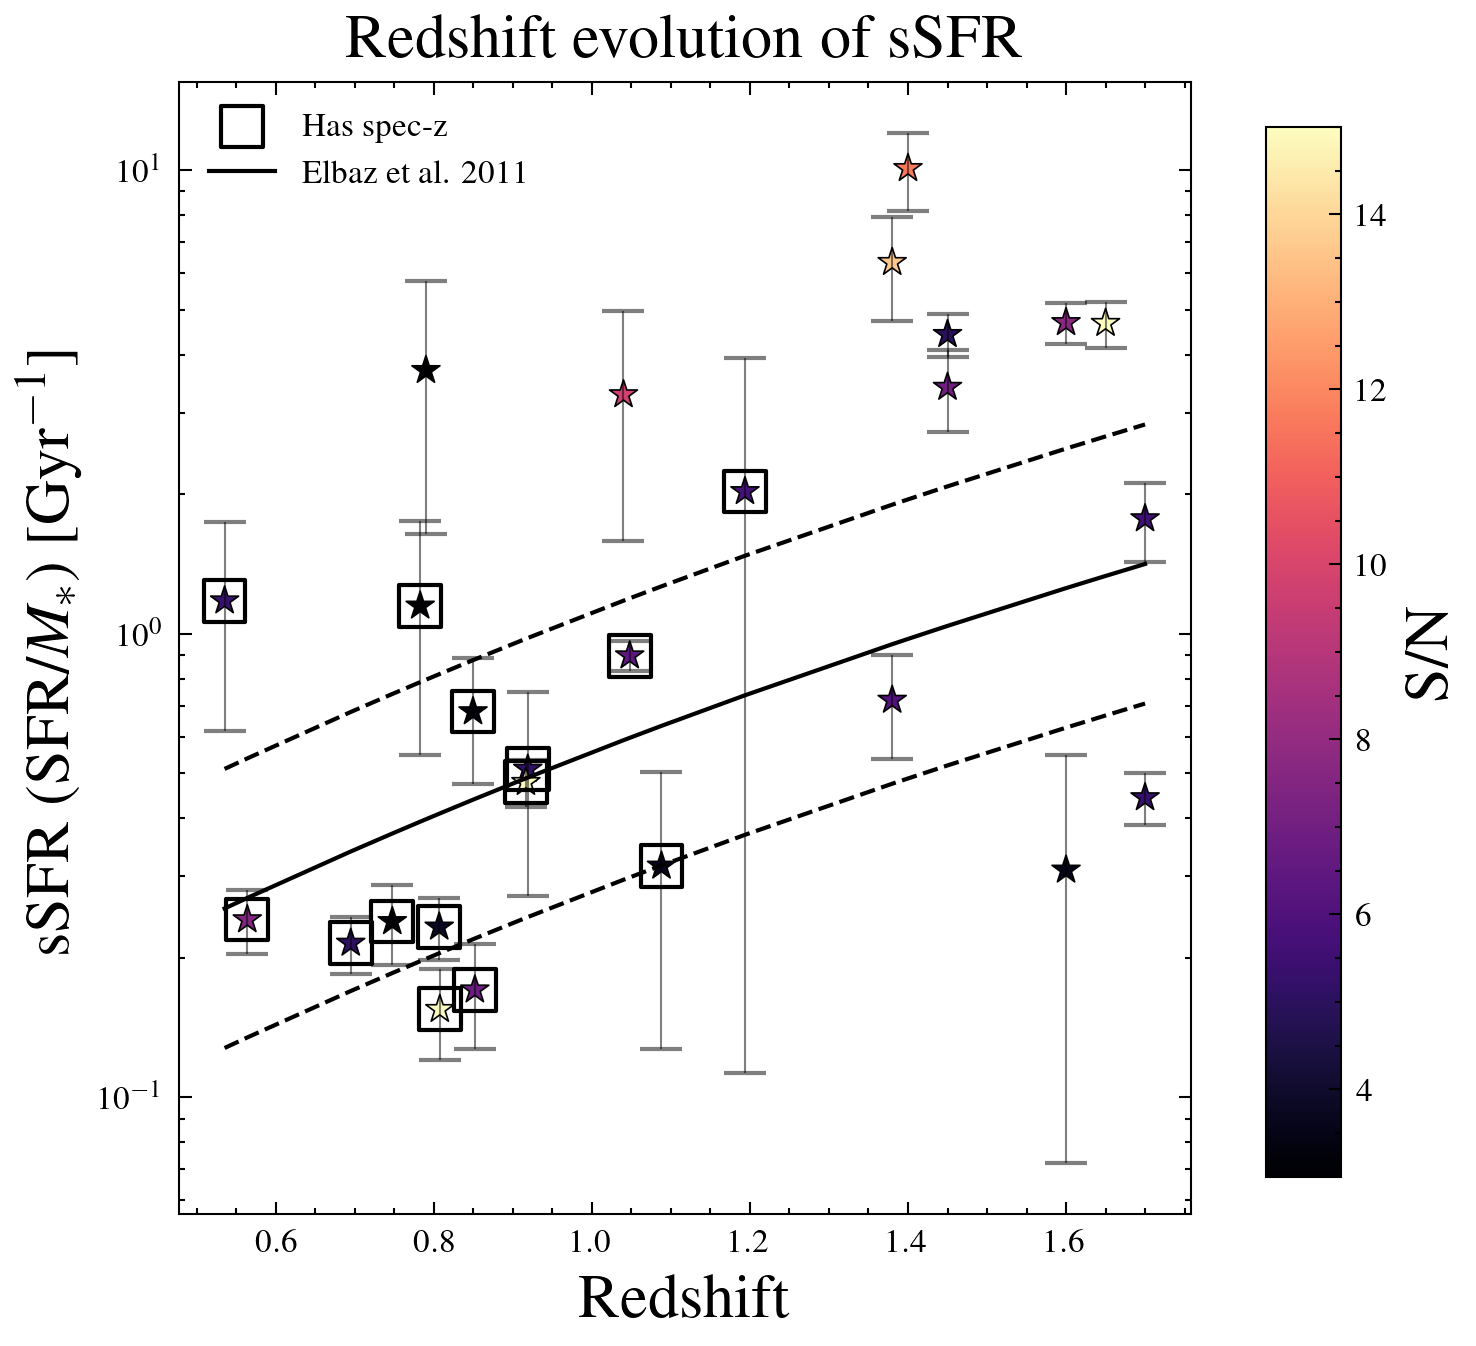

In [181]:
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (5,5))
vmin = 3
vmax = 15
im=ax.scatter(master_df['redshift'], master_df['sSFR_gyr'], c = master_df['S/N'],  marker = '*', s = 50, vmin = vmin, vmax = vmax, cmap = 'magma', edgecolors='black', lw = 0.4)
ax.errorbar(master_df['redshift'], master_df['sSFR_gyr'], yerr = master_df['sSFR_err_gyr'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 0.5)
# for i, txt in enumerate(ms_results['index']):
#     ax[0].annotate(txt, (ms_results['redshift'][i], ms_results['sSFR_gyr'][i] - 0.04))
# ax.scatter(sb_results['redshift'], sb_results['sSFR_gyr'], color = 'purple', marker = '*',facecolors='none')
# ax.errorbar(sb_results['redshift'], sb_results['sSFR_gyr'], yerr = sb_results['sSFR_err_gyr'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
# for i, txt in enumerate(sb_results['index']):
#     ax[0].annotate(txt, (sb_results['redshift'][i], sb_results['sSFR_gyr'][i]- 0.04))
ax.set_yscale('log')

# ax[0].scatter(nr_data['redshift'], nr_data['sSFR_gyr'], marker = 'o', facecolors = 'none', color = 'green', linewidth = 1, s = 200)
ax.scatter(specz['redshift'], specz['sSFR_gyr'], marker = 's', color = 'black', linewidth = 1, label = 'Has spec-z', facecolors = 'none', s = 100)
# ax.scatter(sb_specz['redshift'], sb_specz['sSFR_gyr'], marker = '*', color = 'purple', linewidth = 1)
ax.set_ylabel("sSFR (SFR/$M_*$) [Gyr$^{-1}$]", size = 15)
ax.set_xlabel("Redshift", size = 15)
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']), color = 'black', linewidth = 1, label = 'Elbaz et al. 2011')
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']*2), color = 'black', ls = "--", linewidth = 1)
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']/2), color = 'black', ls = "--", linewidth = 1)
ax.set_title("Redshift evolution of sSFR", size = 15)
ax.legend()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("S/N", size = 15)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/ssfr_z.png", dpi = 300)

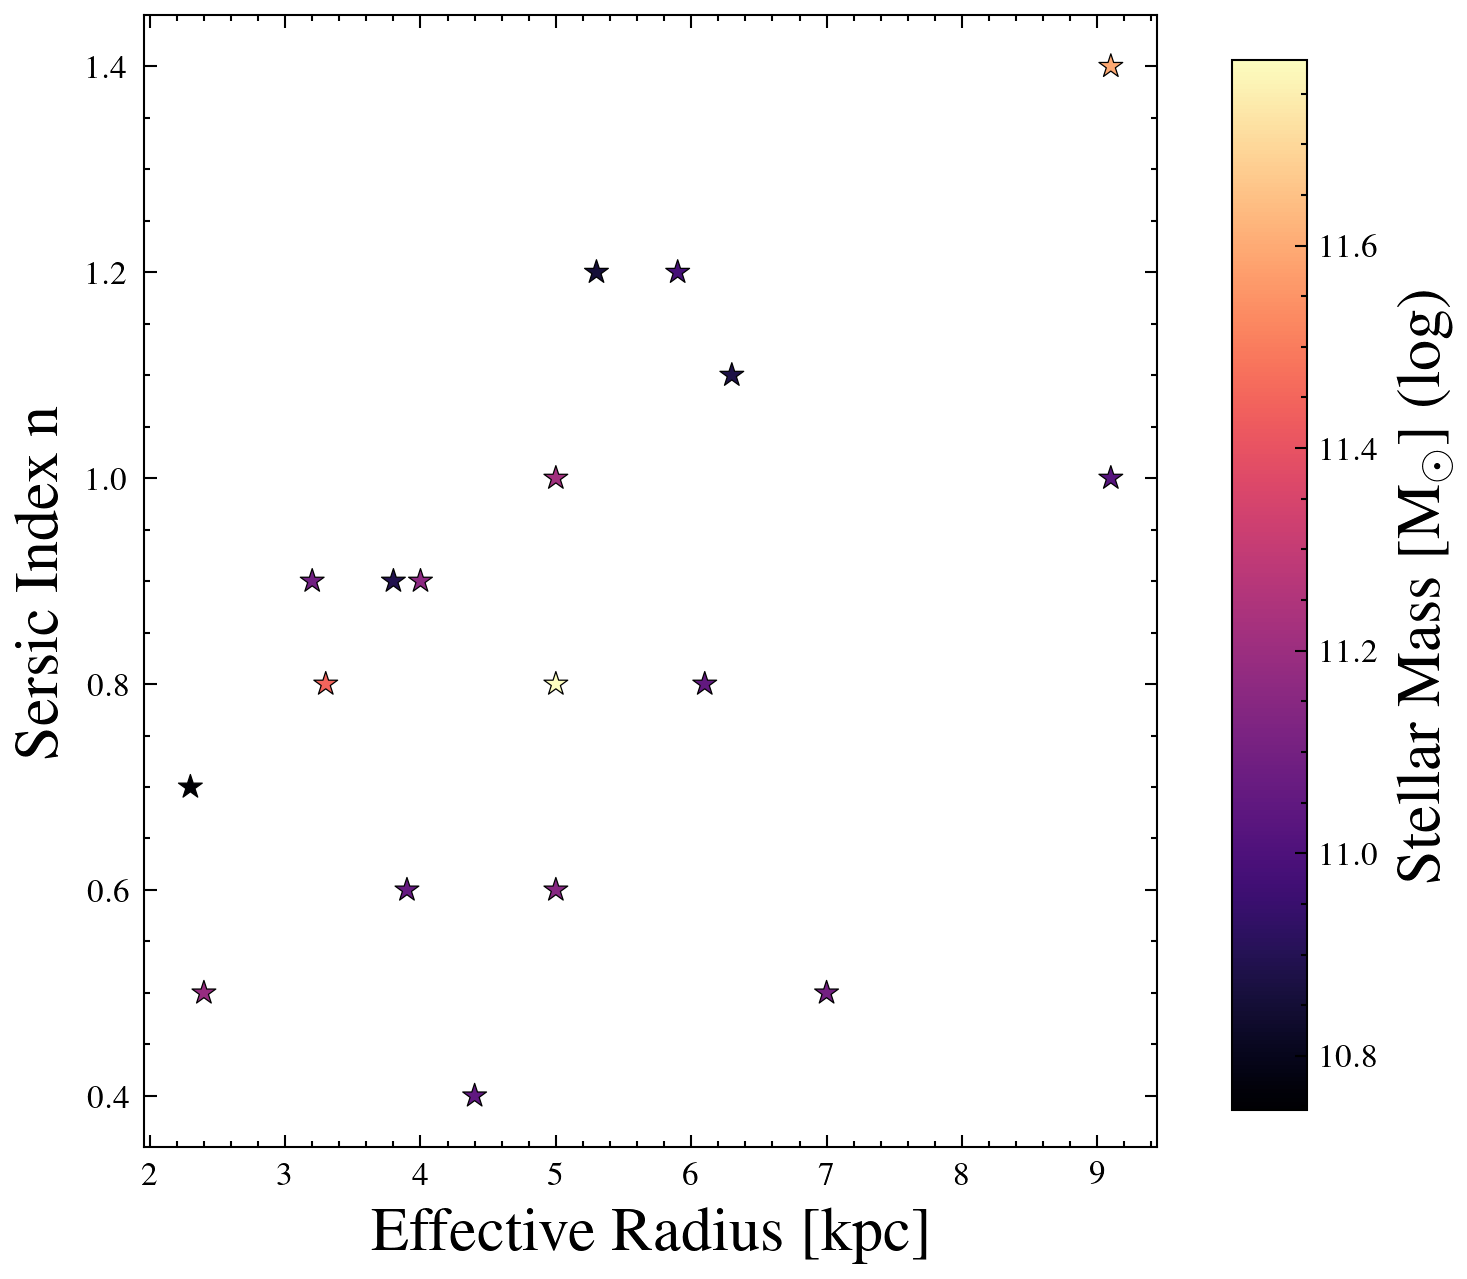

In [58]:
%matplotlib inline
vmin = np.min(np.log10(master_df['Stellar_mass']))
vmax = np.max(np.log10(master_df['Stellar_mass']))
plt.style.use(["ieee","science"])
fig, ax = plt.subplots(1,1,dpi = 300, figsize = (5,5))
im = ax.scatter(master_df['re'], master_df['n'], marker = '*',facecolors='none', edgecolors = 'black', lw = 0.3, c = np.log10(master_df['Stellar_mass']), vmin = vmin, vmax = vmax, cmap = 'magma')
ax.set_xlabel("Effective Radius [kpc]", size = 15)
ax.set_ylabel("Sersic Index n", size = 15)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("Stellar Mass [M$_\odot$] (log)", size = 15)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/n_re.png", dpi = 300)

# Hodge SMGs

In [31]:
from uncertainties import ufloat
from uncertainties.umath import *
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
smg_sm = pd.read_csv("/Users/arames52/Research/Data/aless_smgs.txt", names = ["id", "MH", "z"], delim_whitespace=True)
def mh_to_mstar(mh):
    log_mstar = (ufloat(-0.393, 0.002) * mh) + ufloat(1.22, 0.04)
    return log_mstar
smg_morph = pd.read_csv("/Users/arames52/Research/Data/hodge_smg.txt", names=["id", "Re", "n"], 
                       delim_whitespace=True)
mh_arr = list(smg_sm['MH'])
hodge_smg = smg_sm.merge(smg_morph)
hodge_smg['mstar'] = mh_to_mstar(hodge_smg['MH'])
stellar_mass = []
stellar_mass_err = []
for ind, row in hodge_smg.iterrows():
    stellar_mass.append(row['mstar'].n)
    stellar_mass_err.append(row['mstar'].std_dev)
hodge_smg['stellar_mass'] = stellar_mass
hodge_smg['stellar_mass_err'] = stellar_mass_err
hodge_smg['Re_kpc'] = (cosmo.kpc_proper_per_arcmin(np.array(hodge_smg['z']))*(np.array(hodge_smg['Re']))/60).value
hodge_smg['rest_wave'] = 0.87/(1 + hodge_smg['z'])
hodge_smg['median_SFR'] = 500

In [32]:
etg = pd.read_csv("/Users/arames52/Research/Data/mnras0382-0109-SD1.csv")
# etg = etg[etg['z'].between(0.7,1.7)]
etg['re'] = etg['ae']*np.sqrt(1-etg['epsilon'])
etg['re_kpc'] = (cosmo.kpc_proper_per_arcmin(np.array(etg['z']))*(np.array(etg['re']))/60).value
etg['stellar_mass_log'] = np.log10(np.array(etg['stellar_mass'])*10**10)
etg['rest_wave'] = 0.00081/(1+etg['z'])
hst_bcgs = pd.read_csv("/Users/arames52/Downloads/table2.dat.txt", delim_whitespace=True, names = ["name", "class", "model", "mag", 
                                                                                                  "mean_sb", "re", "n", "b/a", "pa", 
                                                                                                   "align"])
hst_bcgs_tab1 = pd.read_csv("/Users/arames52/Downloads/table1.dat.txt", delim_whitespace=True, names = ["name", "ra",
                                                    "dec", "z", "class", "inst", "filter", "scale", "color"])
hst_bcgs_mass = pd.read_csv("/Users/arames52/Research/Data/hst_bcgs_mass.dat.txt", delim_whitespace = True, names = ["name", "ra", "dec", "r_pos",
                                                                                                                    "M200", "E_M200", "e_M200", "Method", "r-M200",
                                                                                                                    "PAcl", "e_PAcl","r"])
hst_bcgs_mass = hst_bcgs_mass[["name", "M200", "e_M200"]]
hst_bcgs = hst_bcgs.merge(hst_bcgs_tab1, on = "name")
hst_bcgs = hst_bcgs.merge(hst_bcgs_mass, on = "name")
hst_bcgs = hst_bcgs[hst_bcgs['model'] == "Sersic"]
# hst_bcgs = hst_bcgs[hst_bcgs['z'].between(0.7,1.7, inclusive = "both")]
# np.unique(hst_bcgs['filter'])
# hst_filters = {"F105W" : 1055.2, "F125W" : 1248.6, "F140W" : 1392.3, "F160W": 1536.9, "F814W": 8115.3, "F850LP":9145.2}
# hst_bcgs['rest_wave'] = 0
# for ind, row in hst_bcgs.iterrows():
#     hst_bcgs.loc[ind, 'rest_wave'] = hst_filters[row['filter']]*1e-6 / (1+ row['z'])

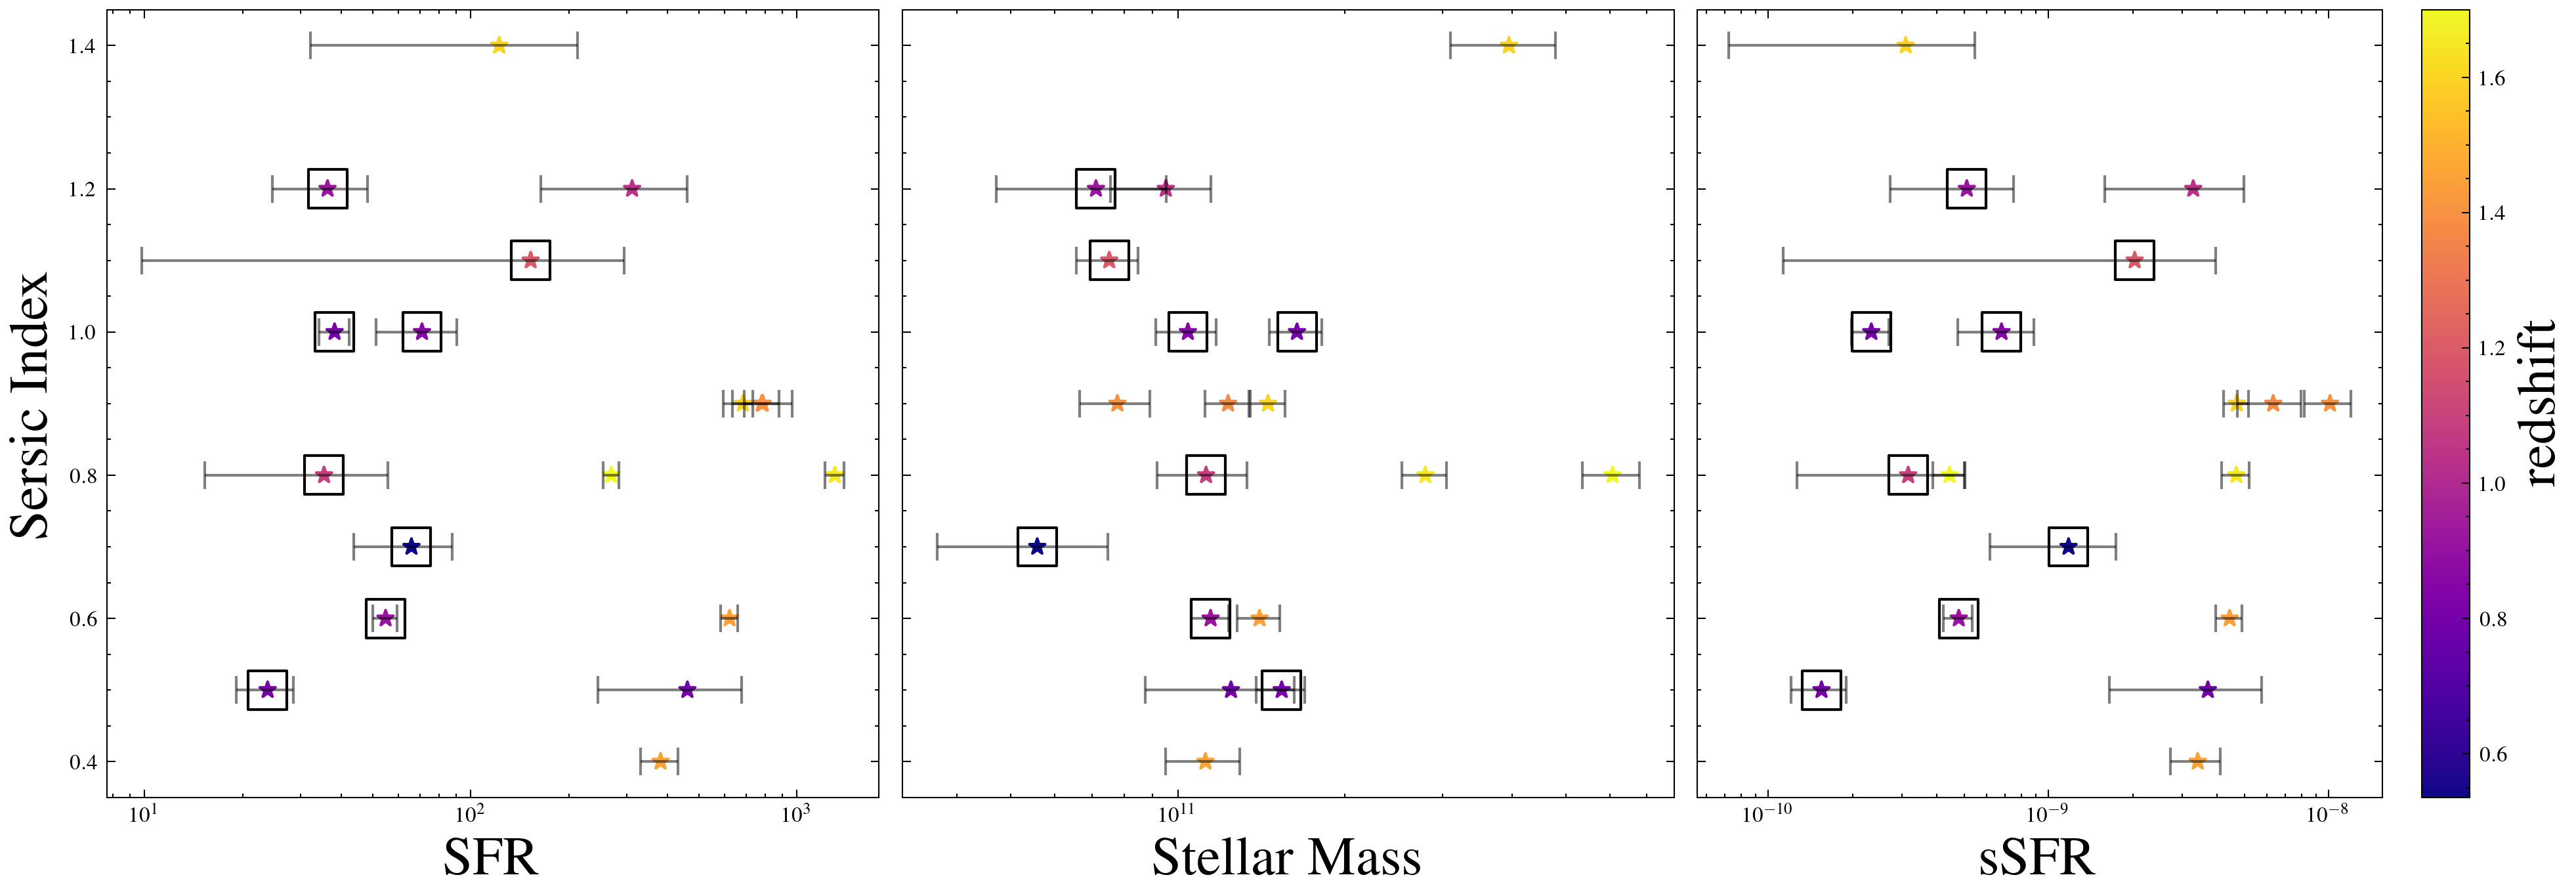

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,3, figsize = (15,5), sharey = True, dpi = 300)
vmin, vmax = min(master_df['redshift']), max(master_df['redshift'])
ax[0].scatter(master_df['SFR'], master_df['n'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[0].scatter(specz['SFR'], specz['n'], marker = 's', s = 200, color = 'black', facecolors = 'none', label = '$z_{spec}$')
ax[0].errorbar(master_df['SFR'], master_df['n'], xerr = master_df['SFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].set_xscale("log")
ax[0].set_ylabel("Sersic Index", size = 20)
ax[0].set_xlabel("SFR",size = 20)
# ax[0].legend()

ax[1].scatter(master_df['Stellar_mass'], master_df['n'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[1].errorbar(master_df['Stellar_mass'], master_df['n'], xerr = master_df['Stellar_mass_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[1].scatter(specz['Stellar_mass'], specz['n'], marker = 's', s = 200, color = 'black', facecolors = 'none', label = '$z_{spec}$')
ax[1].set_xscale("log")
ax[1].set_xlabel("Stellar Mass", size = 20)
# ax[1].legend()

im = ax[2].scatter(master_df['sSFR'], master_df['n'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[2].errorbar(master_df['sSFR'], master_df['n'], xerr = master_df['sSFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[2].scatter(specz['sSFR'], specz['n'], marker = 's', s = 200, color = 'black', facecolors = 'none')
ax[2].set_xscale("log")
ax[2].set_xlabel("sSFR",size = 20)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size="7%", pad=0.2)
cbar = fig.colorbar(im, cax=cax);
cbar.ax.set_ylabel('redshift',size = 20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.03,
                    hspace=0.05)

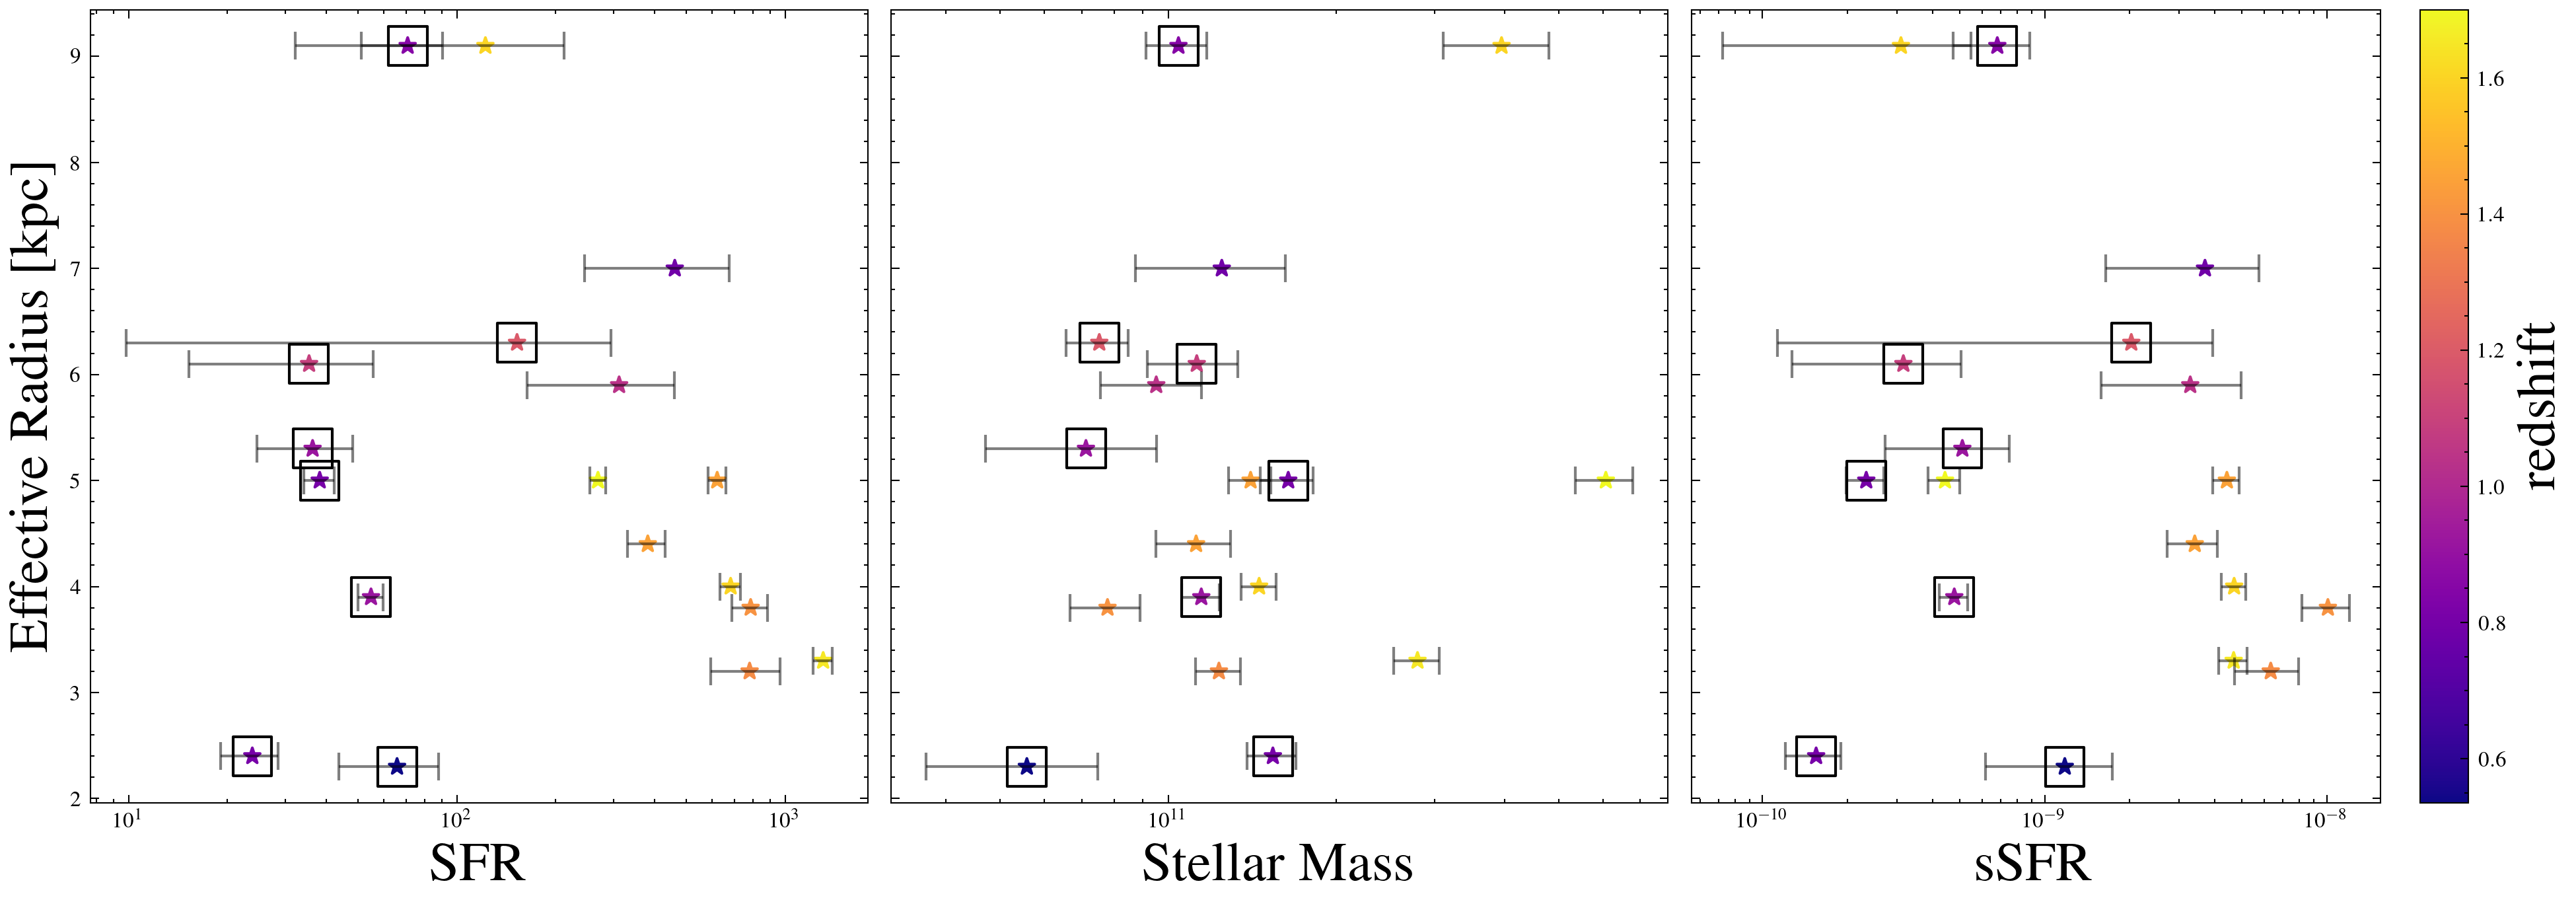

In [34]:
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,3, figsize = (15,5), sharey = True, dpi = 300)
vmin, vmax = min(master_df['redshift']), max(master_df['redshift'])
ax[0].scatter(master_df['SFR'], master_df['re'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[0].scatter(specz['SFR'], specz['re'], marker = 's', s = 200, color = 'black', facecolors = 'none', label = '$z_{spec}$')
ax[0].errorbar(master_df['SFR'], master_df['re'], xerr = master_df['SFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].set_xscale("log")
ax[0].set_ylabel("Effective Radius [kpc]", size = 20)
ax[0].set_xlabel("SFR",size = 20)
# ax[0].legend()

ax[1].scatter(master_df['Stellar_mass'], master_df['re'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[1].errorbar(master_df['Stellar_mass'], master_df['re'], xerr = master_df['Stellar_mass_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[1].scatter(specz['Stellar_mass'], specz['re'], marker = 's', s = 200, color = 'black', facecolors = 'none', label = '$z_{spec}$')
ax[1].set_xscale("log")
ax[1].set_xlabel("Stellar Mass", size = 20)
# ax[1].legend()

im = ax[2].scatter(master_df['sSFR'], master_df['re'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[2].errorbar(master_df['sSFR'], master_df['re'], xerr = master_df['sSFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[2].scatter(specz['sSFR'], specz['re'], marker = 's', s = 200, color = 'black', facecolors = 'none')
ax[2].set_xscale("log")
ax[2].set_xlabel("sSFR",size = 20)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size="7%", pad=0.2)
cbar = fig.colorbar(im, cax=cax);
cbar.ax.set_ylabel('redshift',size = 20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.03,
                    hspace=0.05)

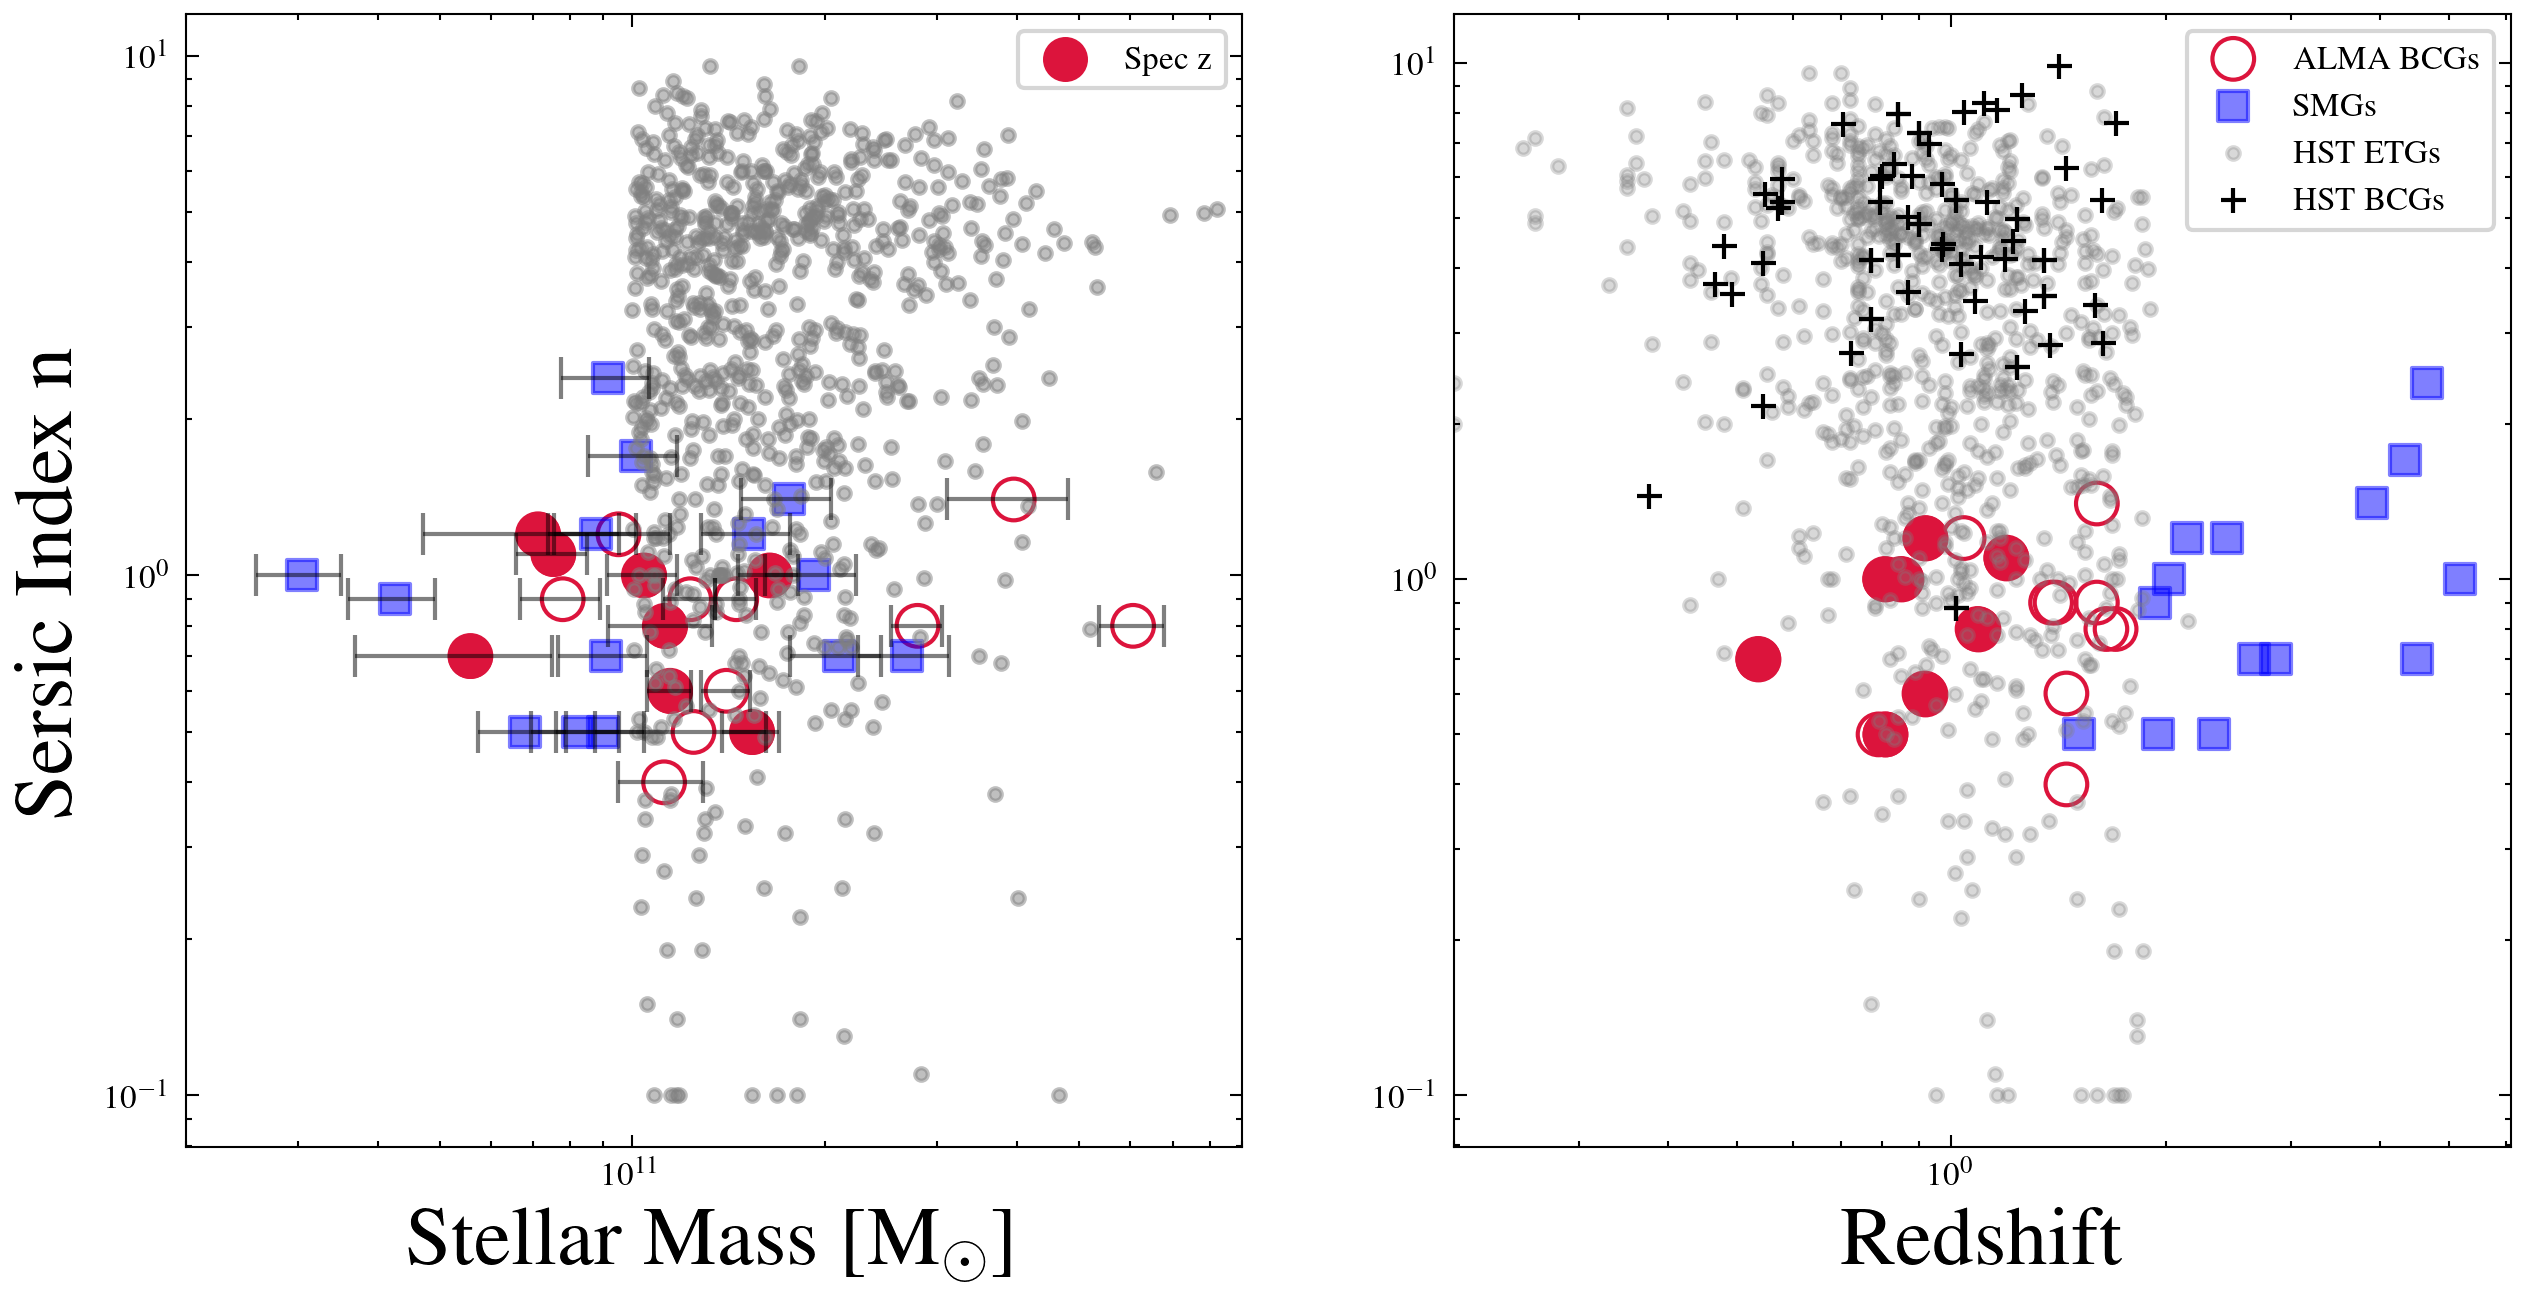

In [60]:
final_results = master_df.copy()
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,2, dpi = 300, figsize = (10,5))
ax[0].scatter(final_results['Stellar_mass'], final_results['n'], marker = 'o', s = 100, color = 'crimson', facecolors = 'none')
ax[0].errorbar(final_results['Stellar_mass'], final_results['n'], xerr = final_results['Stellar_mass_err'],ls = 'none', ecolor = 'black', alpha = 0.5, solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(specz['Stellar_mass'], specz['n'], marker = 'o', s = 100, color = 'crimson', lw = 0.8, label = 'Spec z')
ax[0].scatter(10**hodge_smg['stellar_mass'], hodge_smg['n'], marker = 's',s = 50, color = 'blue', alpha = 0.5)
ax[0].errorbar(10**hodge_smg['stellar_mass'], hodge_smg['n'], xerr = (10**(hodge_smg['stellar_mass'] + hodge_smg['stellar_mass_err']) - 10**(hodge_smg['stellar_mass'])),ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(etg['stellar_mass'] * 10**10, etg['n'], color = 'grey', marker = '.', alpha = 0.5)
ax[0].set_ylabel("Sersic Index n", size = 20)
ax[0].set_xlabel("Stellar Mass [M$_\odot$]", size = 20)
ax[0].set_xscale('log')
ax[0].legend(scatterpoints=1, frameon = True)
ax[0].set_yscale('log')
# ax[0].set_ylim(10**-1)
ax[0].set_xlim(2*10**10, 9*10**11)

ax[1].scatter(final_results['redshift'], final_results['n'], marker = 'o', s = 100, color = 'crimson', facecolors = 'none', label = "ALMA BCGs")
ax[1].scatter(specz['redshift'], specz['n'], marker = 'o', s = 100, color = 'crimson')
ax[1].scatter(hodge_smg['z'], hodge_smg['n'], marker = 's',s = 50, color = 'blue', label = "SMGs", alpha = 0.5)
ax[1].scatter(etg['z'], etg['n'], color = 'grey', marker = '.', alpha = 0.3, label = "HST ETGs")
ax[1].scatter(hst_bcgs['z'], hst_bcgs['n'],  color = 'black', marker = '+', label = 'HST BCGs')
# ax[1].set_ylabel("Effective Radius [kpc]")
ax[1].set_xlabel("Redshift", size = 20)
ax[1].legend(scatterpoints=1, frameon = True)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(2*10**-1)

fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/n_mstar_z.png", dpi = 300)

# plt.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/sn_mass_plot.jpg", dpi = 300,bbox_inches = "tight")

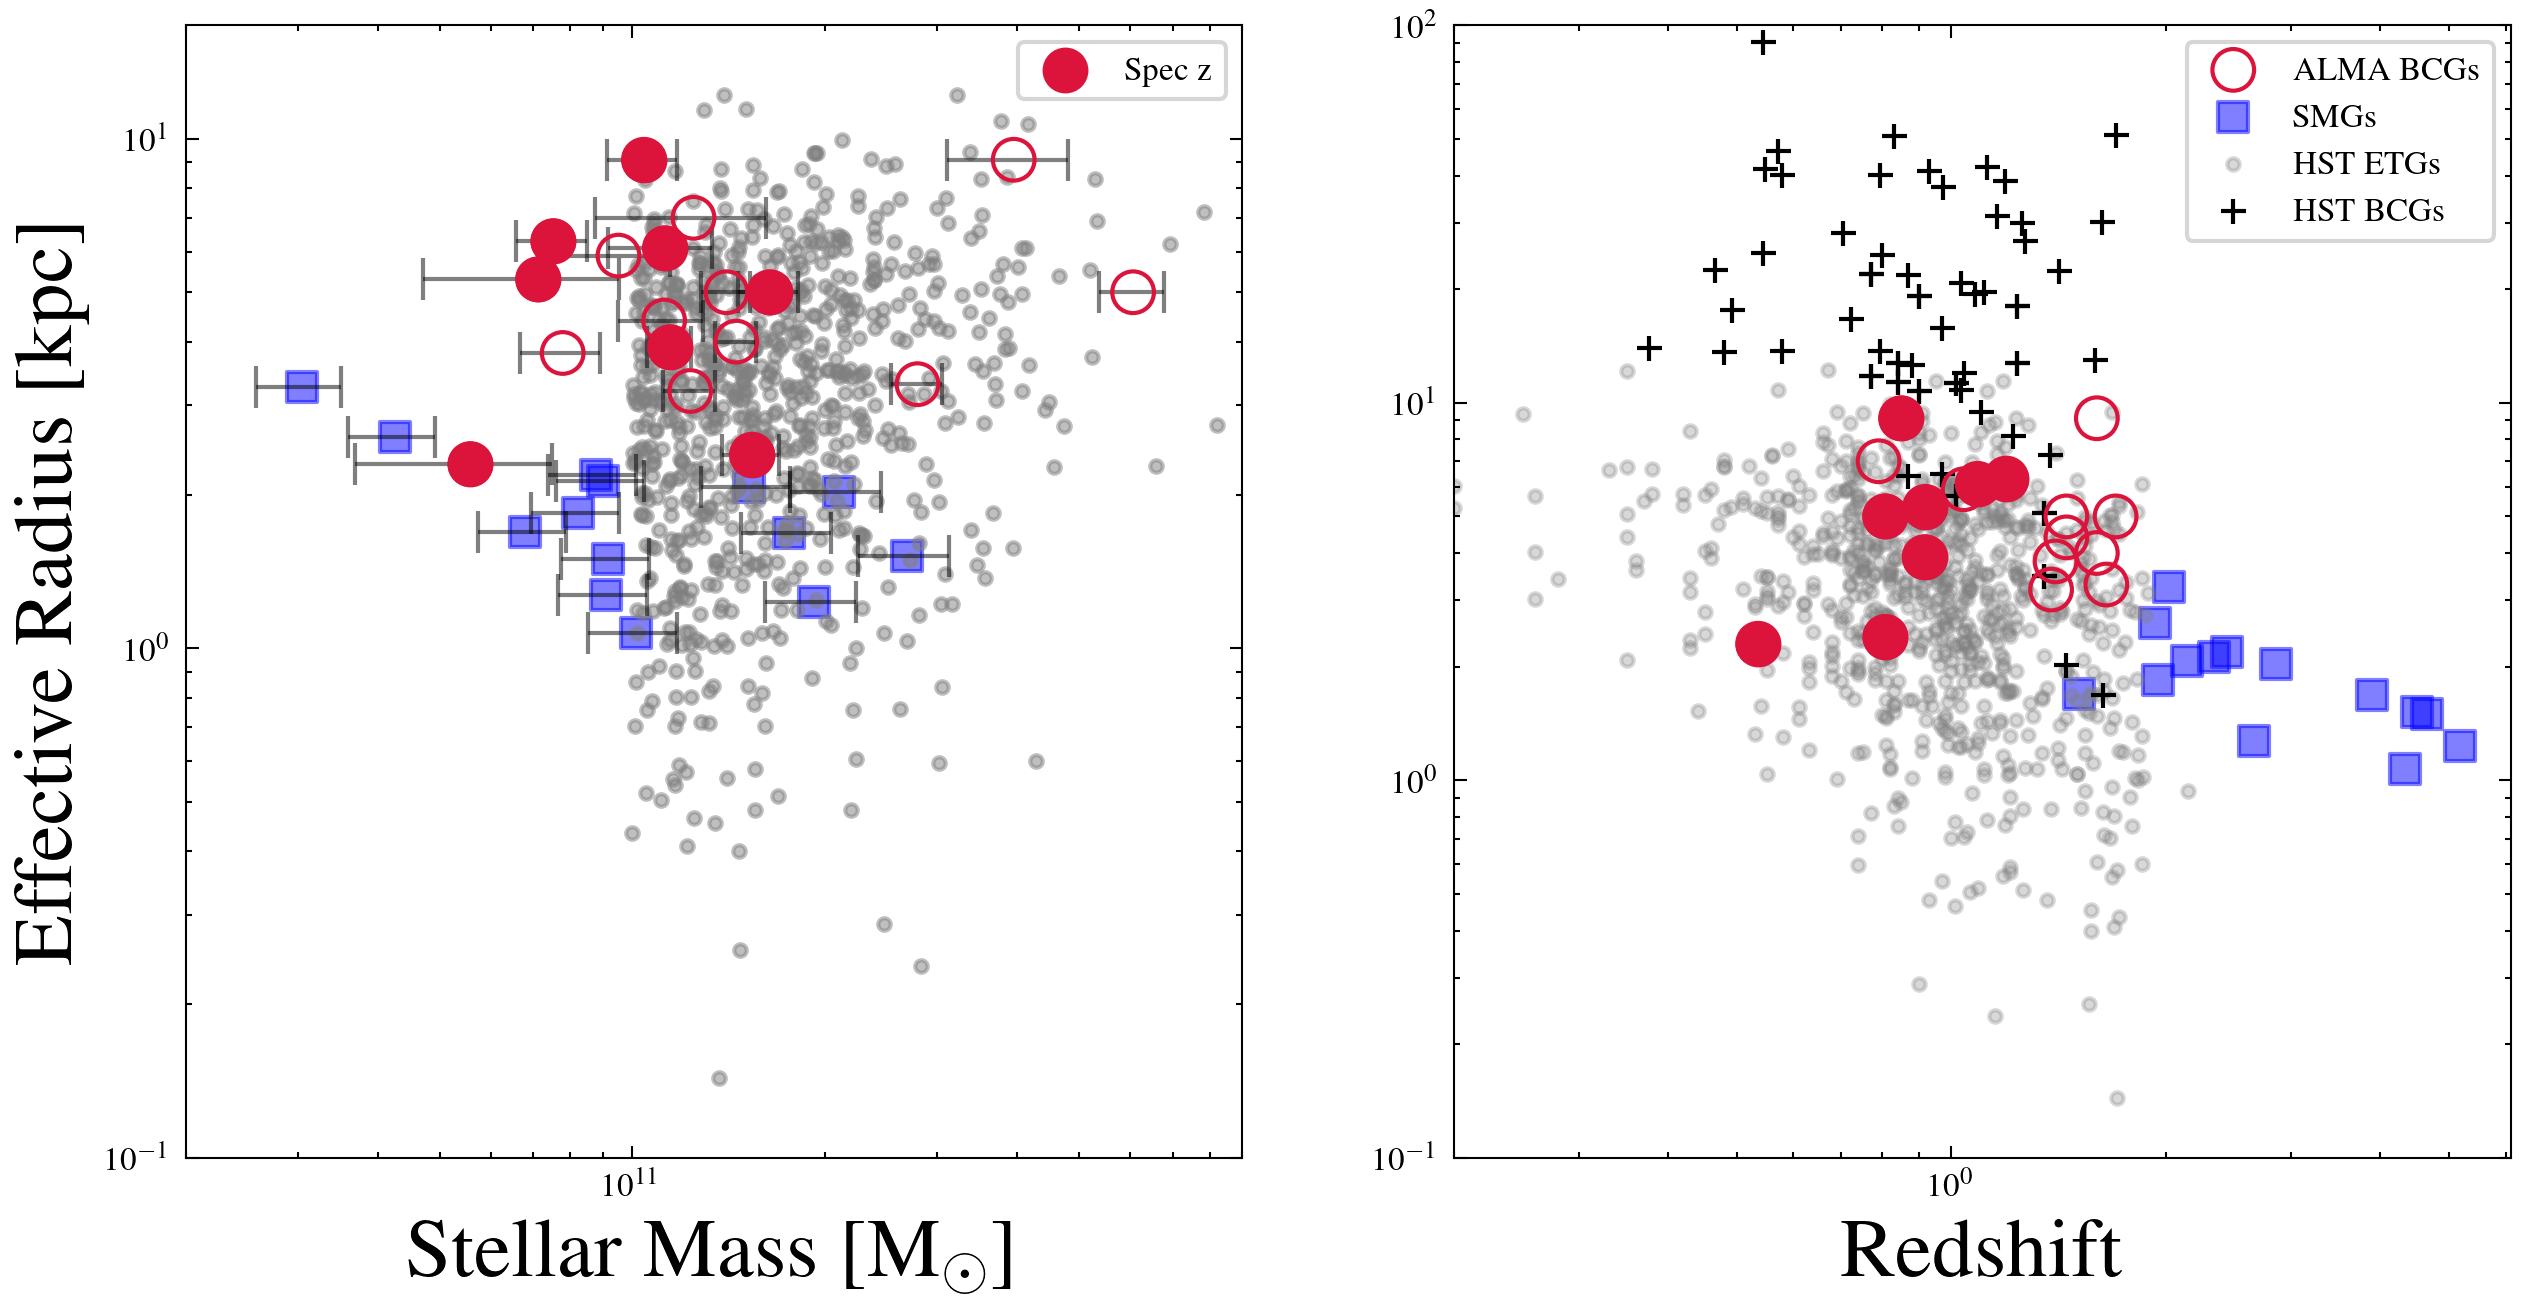

In [59]:
fig,ax = plt.subplots(1,2, figsize = (10,5), dpi = 300)
ax[0].scatter(final_results['Stellar_mass'], final_results['re'], marker = 'o', s = 100, color = 'crimson', facecolors = 'none', zorder = 10)
ax[0].scatter(specz['Stellar_mass'], specz['re'], marker = 'o', s = 100, color = 'crimson', label = "Spec z", zorder = 10)
ax[0].errorbar(final_results['Stellar_mass'], final_results['re'], xerr = final_results['Stellar_mass_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(10**hodge_smg['stellar_mass'], hodge_smg['Re_kpc'], marker = 's',s = 50, color = 'blue', alpha = 0.5)
ax[0].errorbar(10**hodge_smg['stellar_mass'], hodge_smg['Re_kpc'], xerr = (10**(hodge_smg['stellar_mass'] + hodge_smg['stellar_mass_err']) - 10**(hodge_smg['stellar_mass'])),ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(etg['stellar_mass'] * 10**10, etg['re_kpc'], color = 'grey', marker = '.', alpha = 0.5)
ax[0].set_ylabel("Effective Radius [kpc]", size = 20)
ax[0].set_xlabel("Stellar Mass [M$_\odot$]", size = 20)
ax[0].set_xscale('log')
ax[0].legend(scatterpoints=1, frameon = True)
ax[0].set_yscale('log')
ax[0].set_ylim(10**-1)
ax[0].set_xlim(2*10**10, 9*10**11)

ax[1].scatter(final_results['redshift'], final_results['re'], marker = 'o', facecolors= 'none', s = 100, color = 'crimson', label = "ALMA BCGs", zorder = 10)
ax[1].scatter(specz['redshift'], specz['re'], marker = 'o', s = 100, color = 'crimson', zorder = 10)
ax[1].scatter(hodge_smg['z'], hodge_smg['Re_kpc'], marker = 's',s = 50, color = 'blue', label = "SMGs", alpha = 0.5)
ax[1].scatter(etg['z'], etg['re_kpc'], color = 'grey', marker = '.', alpha = 0.3, label = "HST ETGs")
ax[1].scatter(hst_bcgs['z'], hst_bcgs['re'],  color = 'black', marker = '+', label = 'HST BCGs')
# ax[1].set_ylabel("Effective Radius [kpc]")
ax[1].set_xlabel("Redshift", size = 20)
ax[1].legend(scatterpoints=1, frameon = True)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(10**-1, 10**2)
ax[1].set_xlim(2*10**-1)

fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/re_mstar_z.png", dpi = 300)